By Hattie Chung (contact: hchung@broadinstitute.org) 

Note: "BUCKET_PATH" refers to a private google cloud bucket

### file copy to/from google bucket 

In [ ]:
fig_dir = 'gs://BUCKET_PATH/10x_analysis/20210414_revision2/figures'
ict.copy_figs_to_bucket(sc.settings.figdir, fig_dir, 'umap*leiden*')

### copy data from google bucket

In [ ]:
import os
dest_dir = 'seq_data/20210414_revision_combined'
!mkdir -p $dest_dir
!gsutil cp gs://BUCKET_PATH/10x_analysis/20210414_revision2/terra_sample_sheet.xlsx $dest_dir

In [ ]:
import pandas as pd
samples_df = pd.read_excel(dest_dir+'/terra_sample_sheet.xlsx')
for idx, row in samples_df.iterrows(): 
    extension = os.path.splitext(row['source'])[-1]
    dest_fname = '%s/%s_%s%s' %(dest_dir, row['sample_name'], row['data_type'], extension)
    cmd = 'gsutil -m cp %s %s' %(row['source'], dest_fname)
    os.system(cmd)

In [ ]:
# habib et al. 2020
!gsutil -m cp gs://BUCKET_PATH/10x_data/GSE143758_Admouse_Hippocampus_7m_AllNuclei_UMIcounts.txt .

In [ ]:
source_dir = 'gs://BUCKET_PATH/10x_analysis/20200918_hippocampus_inCITE'
for samp in ['HIP1','HIP2']: 
    cmd_loom = 'gsutil -m cp %s/%s_gex/velocyto_out/velocyto_UGER.loom %s/%s_velocyto.loom' %(source_dir, samp, samp_dir, samp)
    print(cmd_loom)
    os.system(cmd_loom)

## initialize

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import nbimporter
import inCITE_tools as ict
import scvelo as scv

bg = ict.make_gray_monoscale_cmap()

run_folder = '20210414_revision_combined'
samp_dir = 'seq_data/%s' %run_folder

sc.settings.figdir = './analyses/%s' %run_folder
if not os.path.isdir(sc.settings.figdir): os.makedirs(sc.settings.figdir)
sc.settings.verbosity = 1             
sc.logging.print_versions()

# specify experiment variables
samples = ['HIP1','HIP2','fresh']
treatments = ['PBS','KainicAcid']
antibodies = ['p65','c-Fos','NeuN','PU.1']
samples_df = pd.read_excel(samp_dir+'/terra_sample_sheet.xlsx')


-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.1
-----
PIL                 8.2.0
anndata             0.7.6
attr                20.3.0
backcall            0.2.0
cached_property     1.5.2
cffi                1.14.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
descartes           NA
get_version         2.2
google              NA
h5py                3.2.1
idna                2.10
igraph              0.9.1
inCITE_tools        NA
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
joblib              1.0.1
jsonschema          3.2.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.4
llvmlite            0.36.0
matplotlib          3.4.1
mizani              0.7.3
mpl_toolkits        NA
natsort             7.1.1
nbformat            5.1.2
nbimporter          NA
numba               0.53.1
numexpr             2.7.3
numpy               1.20.2
packaging     

## Data loading

### Save data from Habib et al. Nature Neuroscience 2020 as anndata object

In [ ]:
# process and save Naomi's data
ad = sc.read('GSE143758_Admouse_Hippocampus_7m_AllNuclei_UMIcounts.txt')
ad_habib = ad.T
detergents = []
for i in ad_habib.obs.index: 
    a = i.split('_')
    detergent, sample, bead_barcode = a[0], a[1], a[2]
    b = sample.split('-')
    region, genotype, x, age = b[0], b[1], b[2], b[3]
    
    ad_habib.obs.at[i, 'buffer'] = detergent
    ad_habib.obs.at[i, 'sample'] = sample
    ad_habib.obs.at[i, 'brain_region'] = region
    ad_habib.obs.at[i, 'genotype'] = genotype
    ad_habib.obs.at[i, 'x'] = x
    ad_habib.obs.at[i, 'age'] = age
    
ad_habib.write('./write/naomi_natneurosci_2020.h5ad')

### Data for comparing RNA complexity (ED Fig 5a) 

inCITE-seq sequenced to the same depth (1 channel) + snRNA-seq (1 channel) + Habib et al.

In [9]:
samples_comparison = samples_df.loc[samples_df['sample_name'].isin(['HIP_seq_comparison','fresh'])]
    
# combine across batches
adatas = []
for samp in set(samples_comparison['sample_name']): 
    print(samp)
    
    # demultiplexed gene expression
    samp_gex = '%s/%s_%s%s' %(samp_dir, samp, 'gex', '.h5ad')
    ad = sc.read(samp_gex)
    print('Loaded gene expression matrix, %i by %i' %(demux_gex.shape[0], demux_gex.shape[1]))
        
    adatas.append(ad)

# add naomi's data
print('Loading Naomi\'s data')
ad_habib = sc.read('./write/naomi_natneurosci_2020.h5ad')
ad_wt = ad_habib[(ad_habib.obs['genotype']=='WT')].copy()
ad_wt.obs['assignment'] = 'Habib'
ad_wt.obs['n_counts'] = ad_wt.X.sum(axis=1)
ad_wt.obs['n_genes'] = ad_wt.X.astype(bool).sum(axis=1)
ad_wt.obs['hashtag_counts'] = 0

adatas.append(ad_wt)
adata = adatas[0].concatenate(adatas[1:],join='outer')
adata.var_names_make_unique()

fixed
Loaded gene expression matrix, 18948 by 27998
fresh
Loaded gene expression matrix, 18948 by 27998
Loading Naomi's data


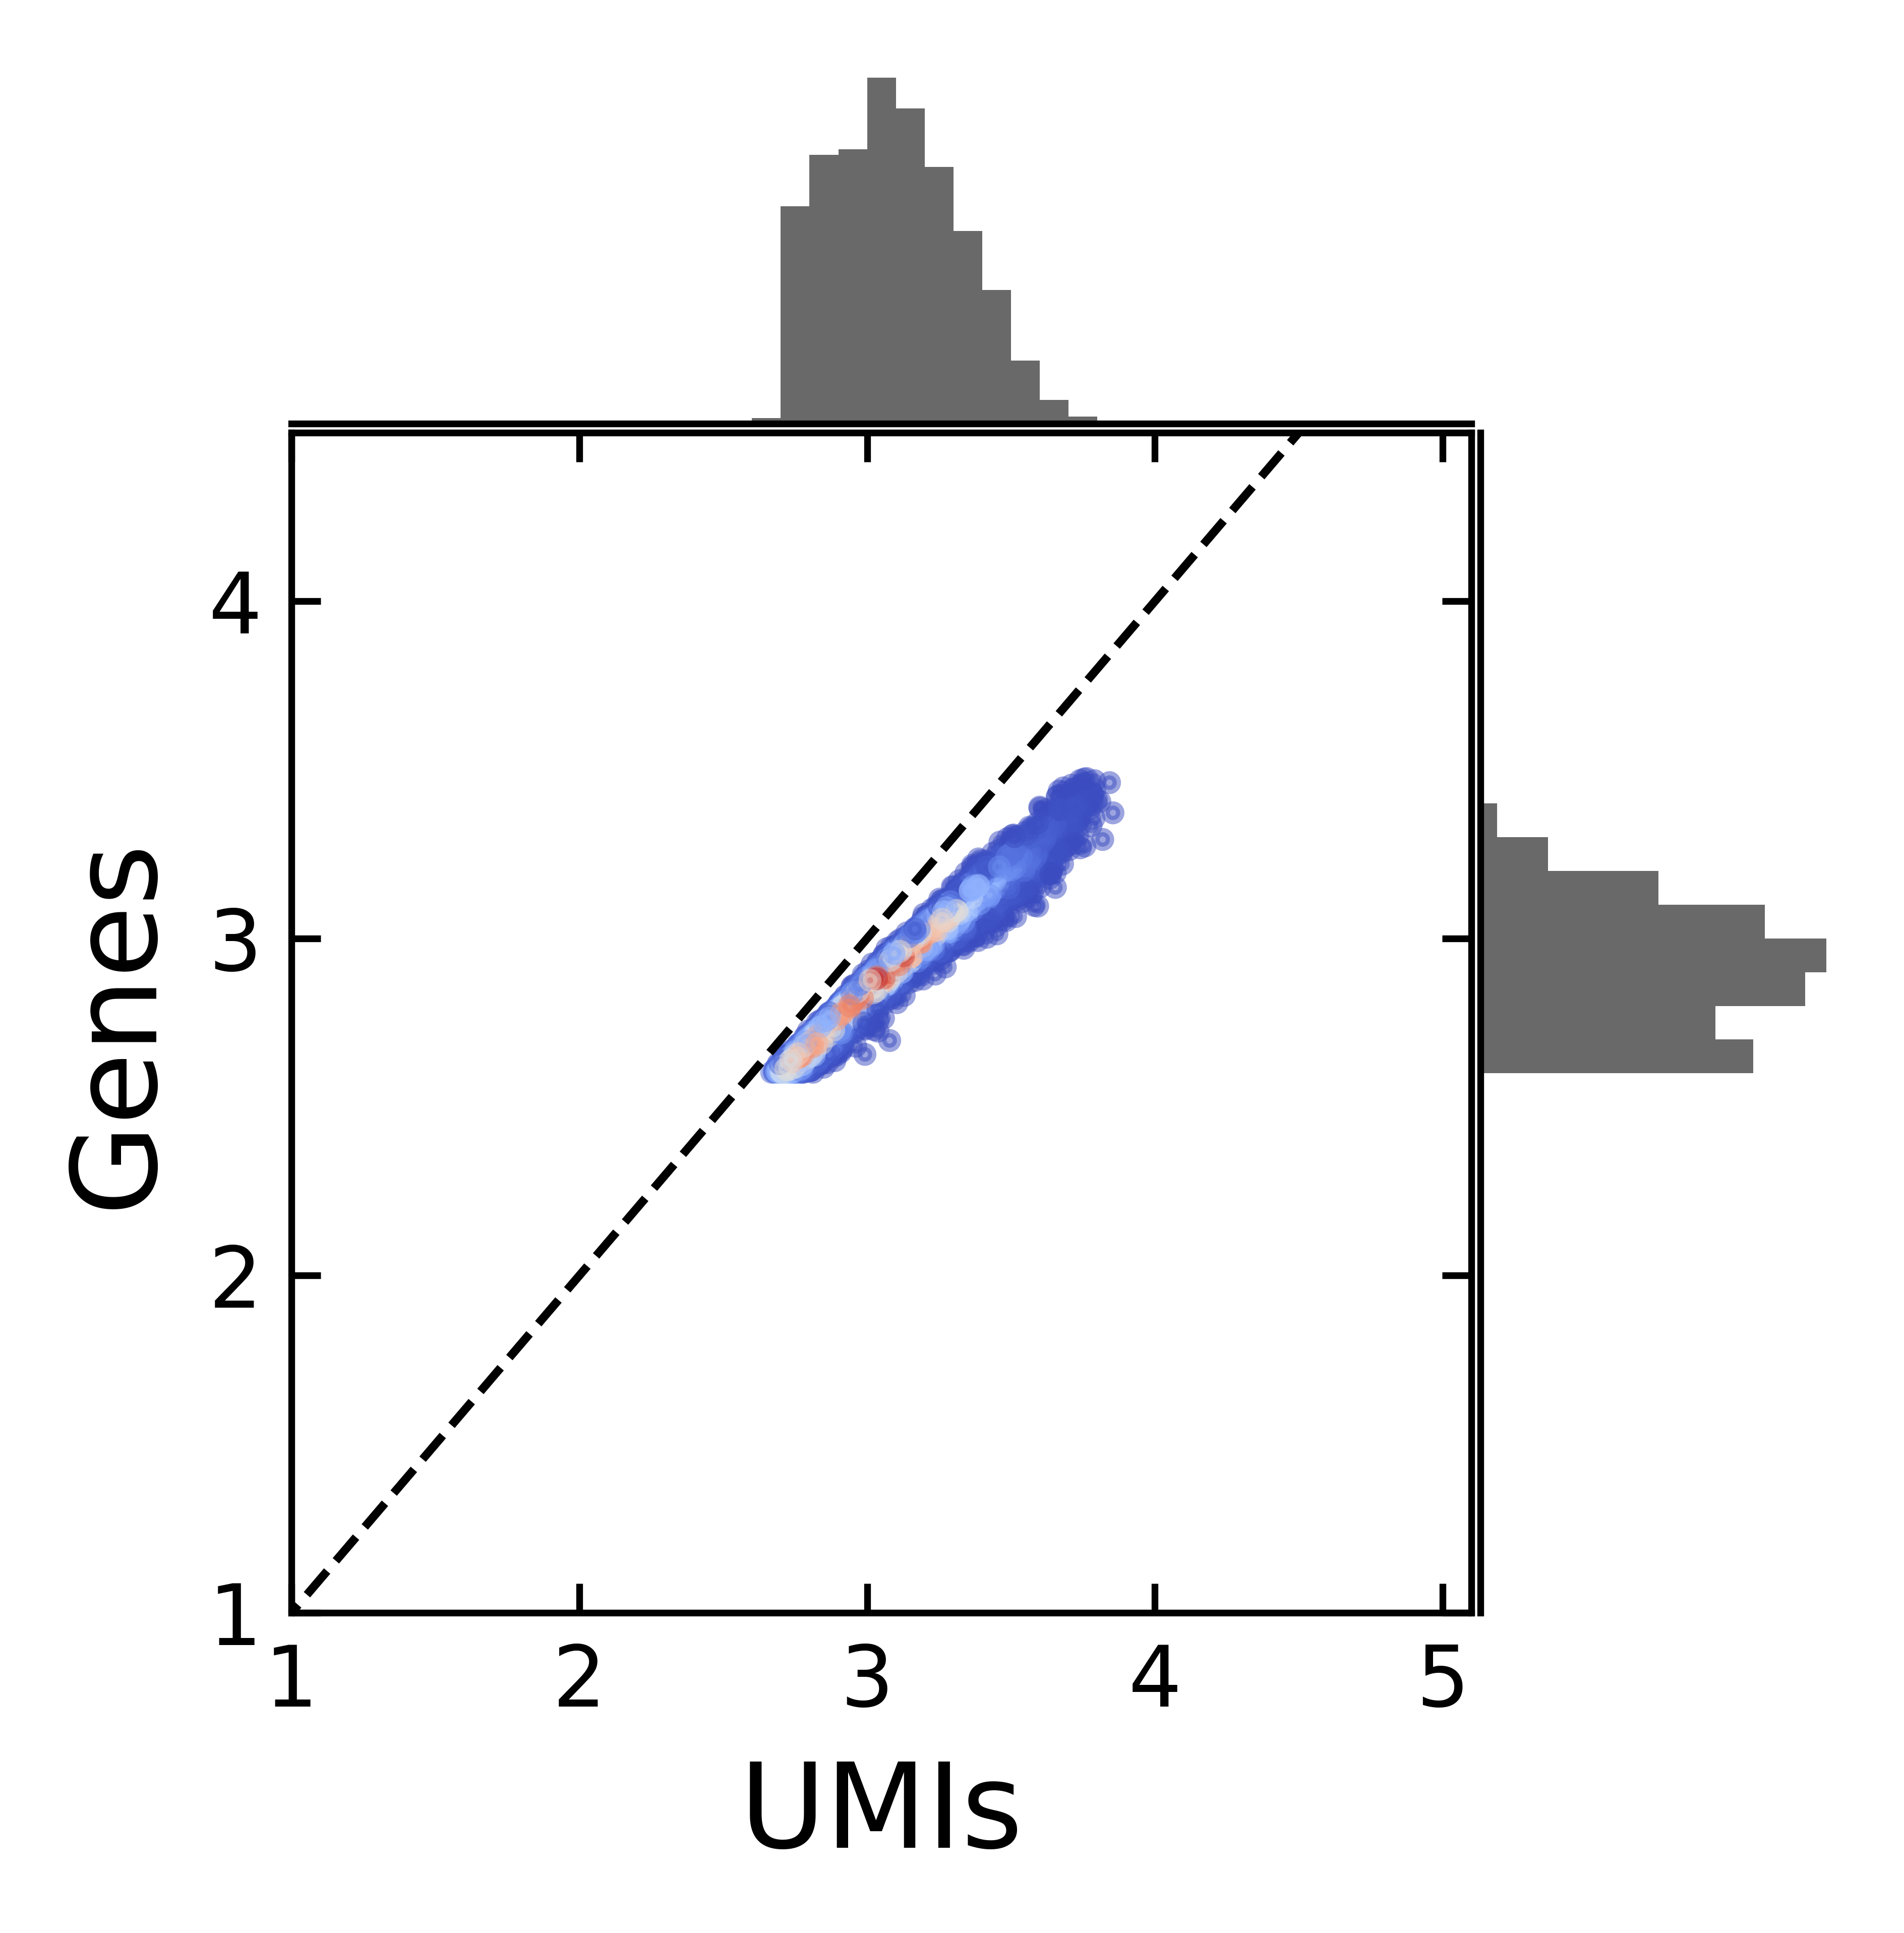

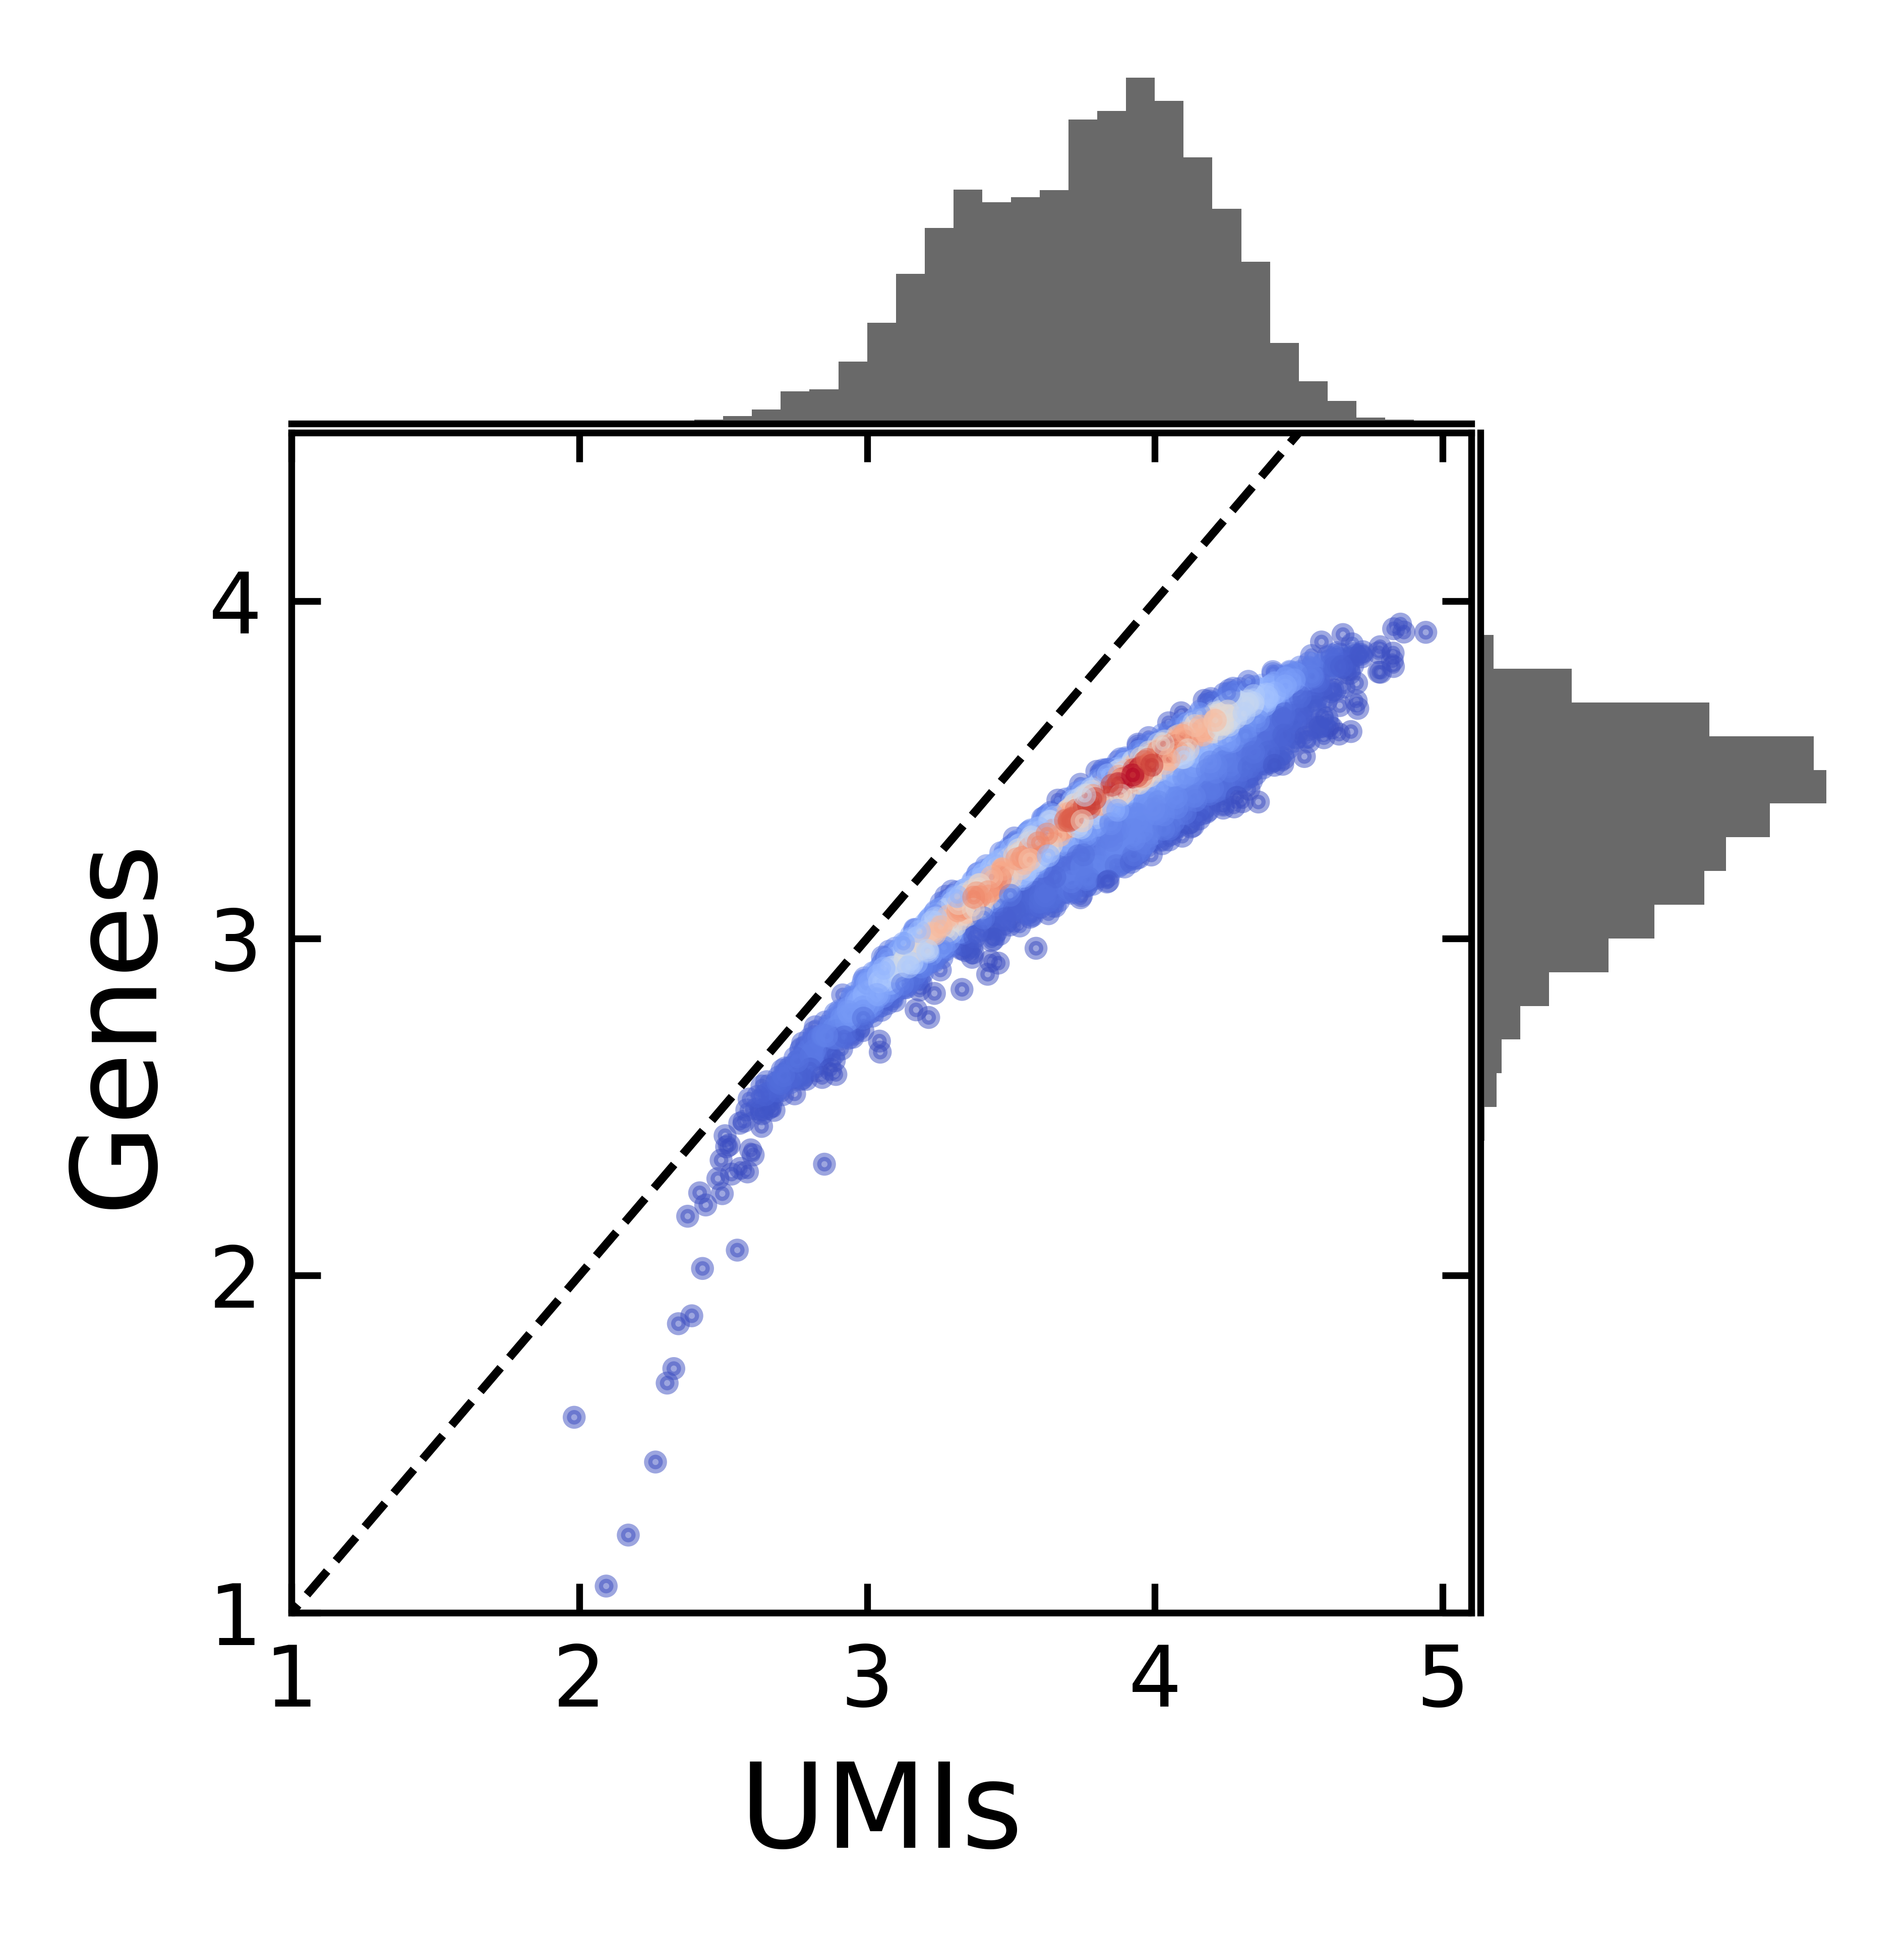

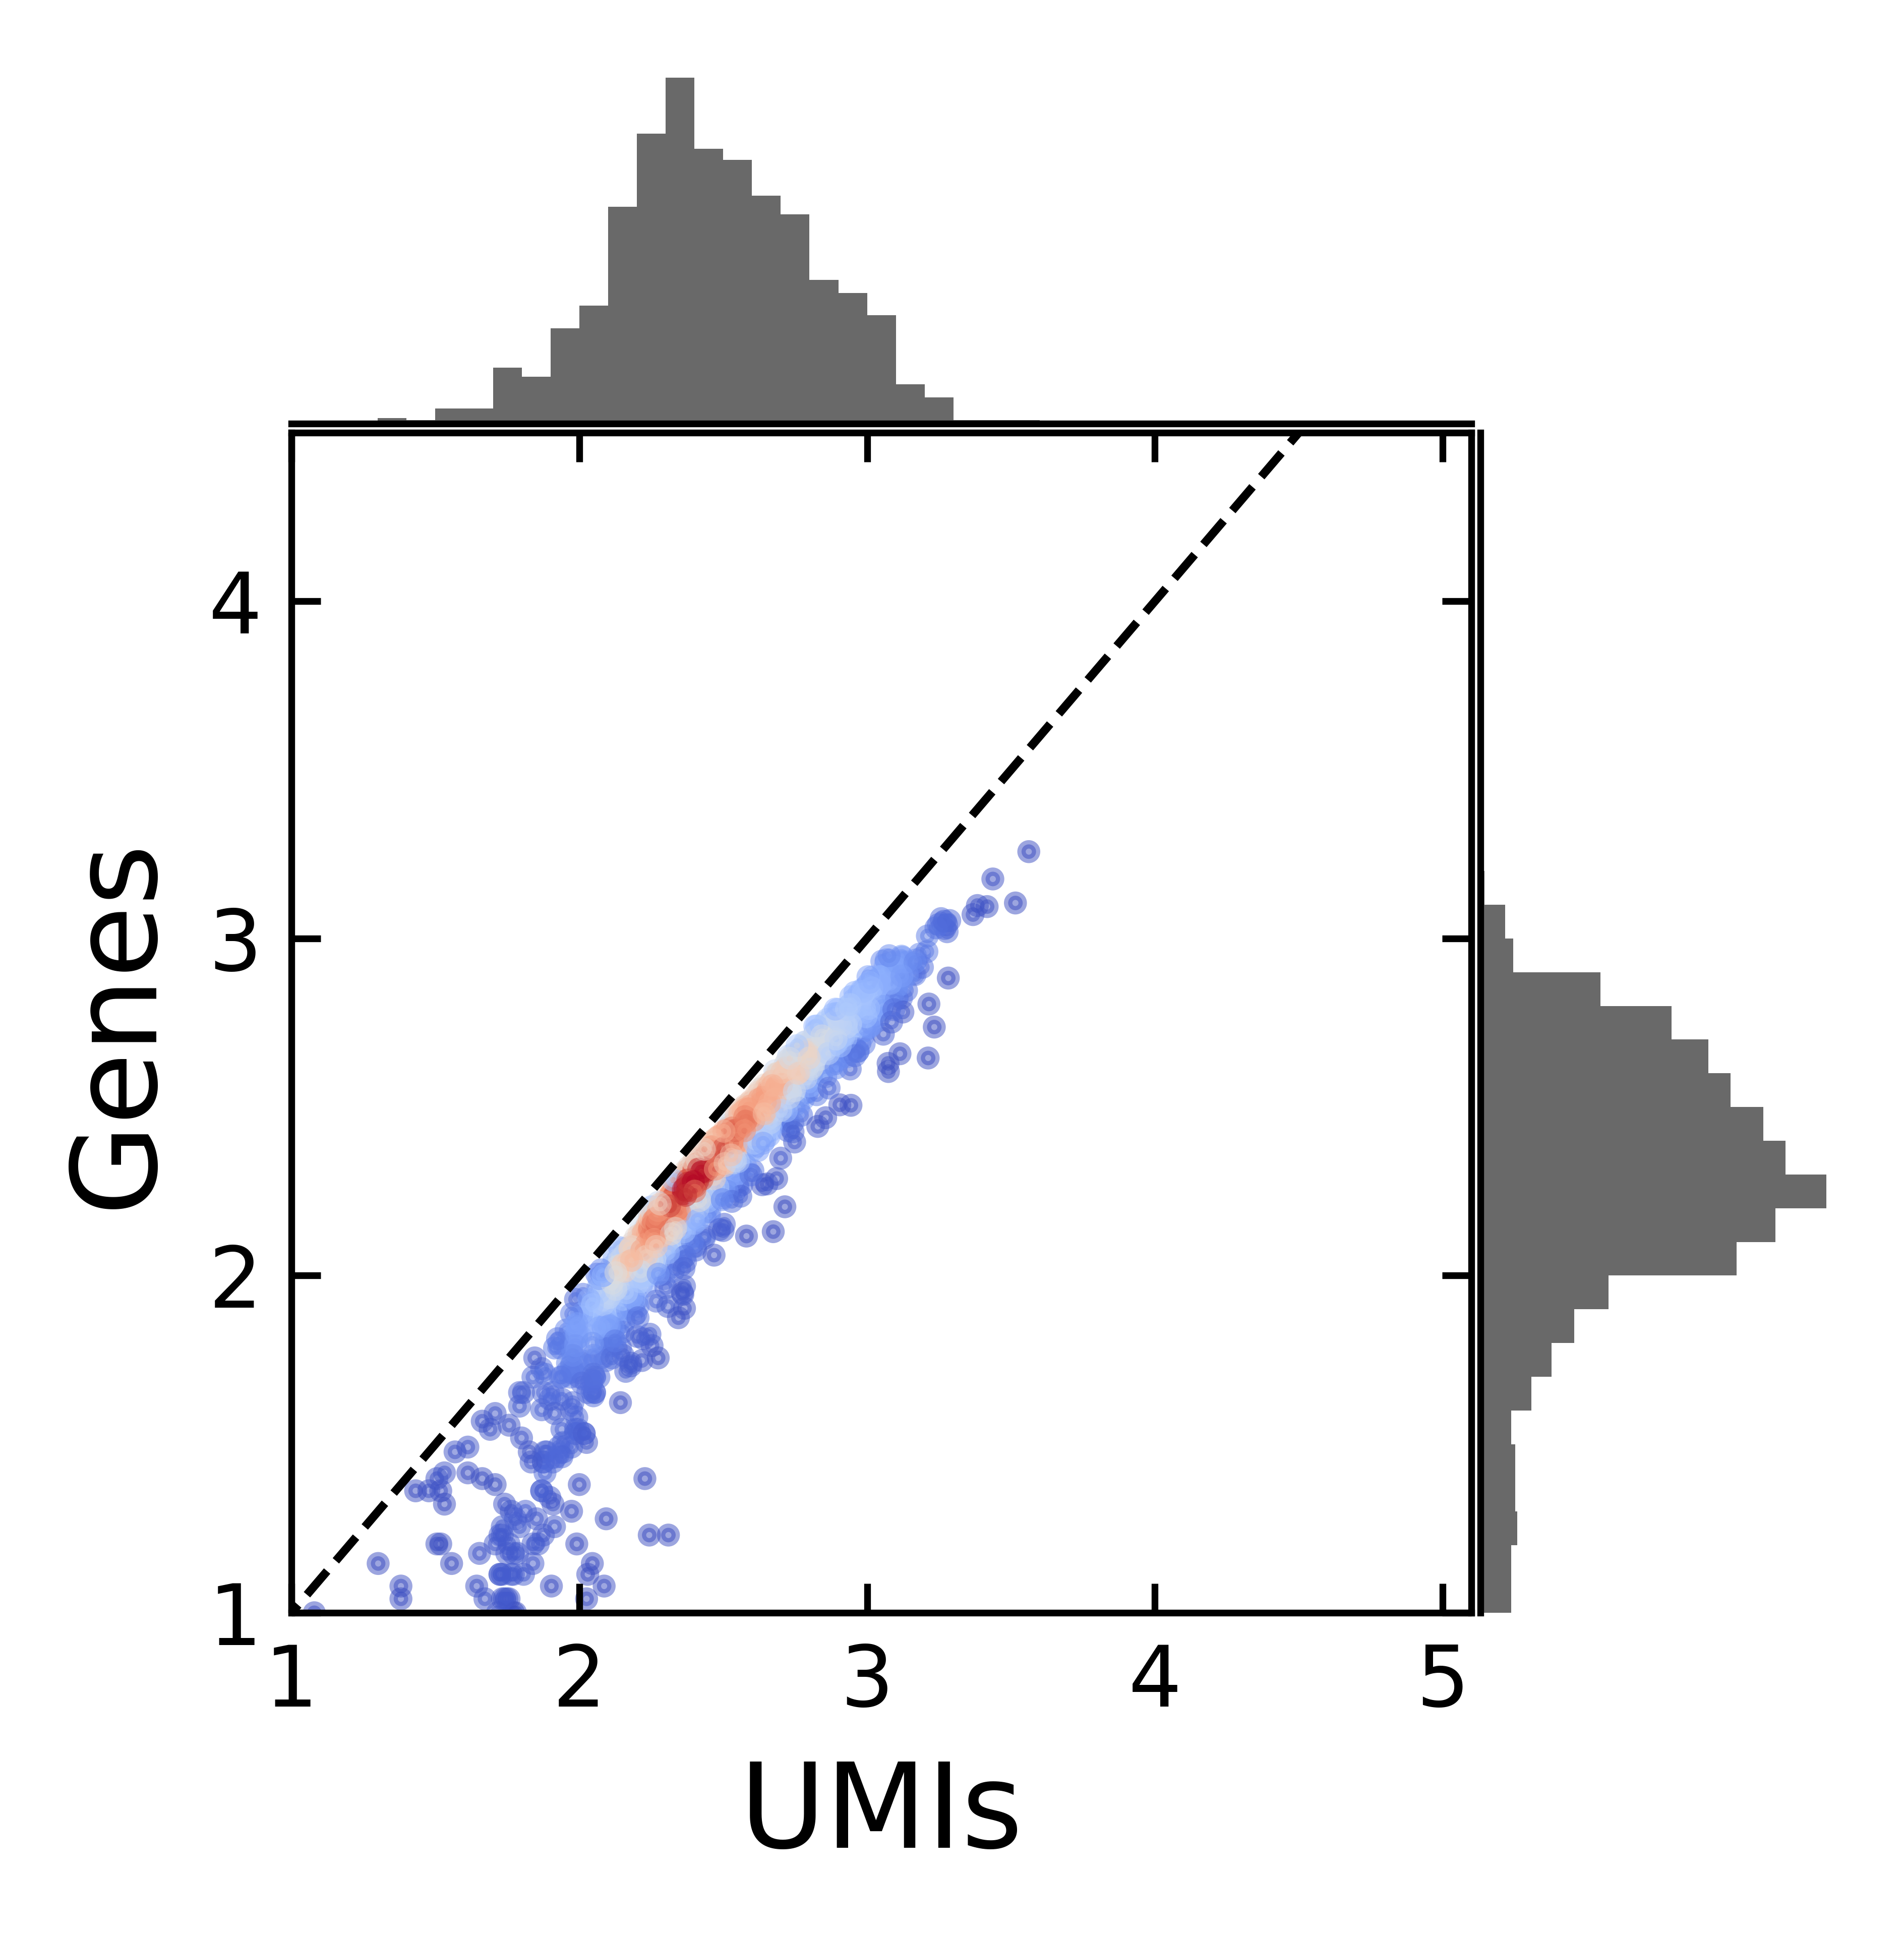

In [12]:
ict.scatter_UMI_genes_hist(adata[adata.obs['batch']=='2'],'fresh_habib', savefig=False)
ict.scatter_UMI_genes_hist(adata[adata.obs['batch']=='1'],'fresh_internal', savefig=False)
ict.scatter_UMI_genes_hist(adata[adata.obs['batch']=='0'],'fixed', savefig=False)

## load data for analysis

In [ ]:
samples_analysis = samples_df.loc[samples_df['sample_name']!='HIP_seq_comparison']

LOAD_ISOFORM_DATA = False

# combine across batches
adatas = []
for samp in set(samples_analysis['sample_name']): 
    print(samp)
    
    # demultiplexed gene expression
    samp_gex = '%s/%s_%s%s' %(samp_dir, samp, 'gex', '.h5ad')
    demux_gex = sc.read(samp_gex)
    print('Loaded gene expression matrix, %i by %i' %(demux_gex.shape[0], demux_gex.shape[1]))
    
    # demultiplexed antibody counts (ADT)
    samp_adt = '%s/%s_%s%s' %(samp_dir, samp, 'adt', '.csv') 
    if os.path.exists(samp_adt): 
        ADTs = pd.read_csv(samp_adt, index_col='Antibody')
        
        # merge gex + ADT
        ad = ict.merge_adt_and_gex(ADTs, demux_gex, antibodies)
        
        print('Loaded ADTs')
    else: 
        ad = demux_gex.copy()
        print('Skipping ADTs for %s' %samp)
    
    # demultiplexed nuclei HTO hashtag counts
    samp_hto = '%s/%s_%s%s' %(samp_dir, samp, 'hto', '.h5ad')
    demux_hashtags = sc.read(samp_hto)
    print('Loaded HTOs')
    
    # append HTO 
    ad.obs['hashtag_counts'] = demux_hashtags.obs['counts']
    
    if LOAD_ISOFORM_DATA: 
    # adding isoform counts (spliced and unspliced from velocyto)
        loom_file = '%s/%s_velocyto.loom' %(samp_dir, samp)
        if os.path.exists(loom_file):
            ldata = scv.read(loom_file, cache=True)
            ad = scv.utils.merge(ad, ldata)
            ad.obs_names_make_unique()
            ad.var_names_make_unique()
            print('Added spliced and unspliced')
    
    adatas.append(ad)

# add naomi's data
print('Loading Naomi\'s data')
ad_habib = sc.read('./write/naomi_natneurosci_2020.h5ad')
ad_wt = ad_habib[(ad_habib.obs['genotype']=='WT')].copy()
ad_wt.obs['assignment'] = 'Habib'
ad_wt.obs['n_counts'] = ad_wt.X.sum(axis=1)
ad_wt.obs['n_genes'] = ad_wt.X.astype(bool).sum(axis=1)
ad_wt.obs['hashtag_counts'] = 0

adatas.append(ad_wt)
adata = adatas[0].concatenate(adatas[1:],join='outer')
adata.var_names_make_unique()

adata.obs['sample_type'] = 'fixed'
adata.obs.loc[adata.obs['batch']=='2','sample_type'] = 'fresh'
adata.obs.loc[adata.obs['batch']=='3','sample_type'] = 'fresh'

### process and save adata containing isoforms

In [12]:
if LOAD_ISOFORM_DATA: 
    print(adata.shape)

    # remove cells with ambiguous assignment from DemuxEM
    # assign treatment (PBS or KA)
    treatments = ['PBS','KainicAcid','Habib']
    adata = adata[adata.obs['assignment'].isin(treatments)]

    # filter cells with low gene count
    sc.pp.filter_cells(adata, min_genes=50) 

    # filter genes with low cell count
    sc.pp.filter_genes(adata, min_cells=3)

    # calculate mitochondrial content
    ict.calc_mito_ncounts(adata)

    # remove unnecessary attributes
    adata.obs.drop(['Channel','demux_type','buffer','sample','brain_region',
                    'genotype','x','age'],axis=1, inplace=True)

    adata.var.drop(['gene_ids-0','robust-0','Accession-0','Chromosome-0','End-0','Start-0','Strand-0',
                    'gene_ids-1','robust-1','Accession-1','Chromosome-1','End-1','Start-1','Strand-1','robust-2'],
                    axis=1, inplace=True)

    adata.write('./write/revision_inCITE_raw_isoform_layers.h5ad')

(43310, 28010)


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 40990 × 21679
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'p65', 'c-Fos', 'NeuN', 'PU.1', 'hashtag_counts', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'buffer', 'sample', 'brain_region', 'genotype', 'x', 'age', 'batch', 'sample_type', 'frac_mito'
    var: 'gene_ids-0', 'robust-0', 'Accession-0', 'Chromosome-0', 'End-0', 'Start-0', 'Strand-0', 'gene_ids-1', 'robust-1', 'Accession-1', 'Chromosome-1', 'End-1', 'Start-1', 'Strand-1', 'gene_ids-2', 'robust-2', 'n_cells'
    obsm: 'raw_probs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## Pre-processing - filtering

In [9]:
print(adata.shape)

# remove cells with ambiguous assignment from DemuxEM
# assign treatment (PBS or KA)
treatments = ['PBS','KainicAcid','Habib']
adata = adata[adata.obs['assignment'].isin(treatments)]

# filter cells with low gene count
sc.pp.filter_cells(adata, min_genes=50) 

# filter genes with low cell count
sc.pp.filter_genes(adata, min_cells=3)

# calculate mitochondrial content
ict.calc_mito_ncounts(adata)

(51919, 28010)


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 44201 × 21711
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'p65', 'c-Fos', 'NeuN', 'PU.1', 'hashtag_counts', 'buffer', 'sample', 'brain_region', 'genotype', 'x', 'age', 'batch', 'sample_type', 'frac_mito'
    var: 'gene_ids-0', 'robust-0', 'gene_ids-1', 'robust-1', 'gene_ids-2', 'robust-2', 'n_cells'
    obsm: 'raw_probs'

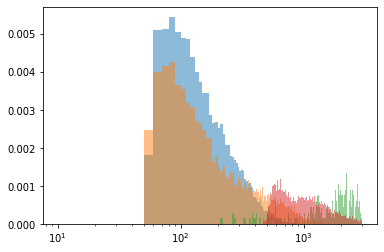

In [5]:
# set batch specific thresholds
bins = np.arange(0,3000,10)
for b in ['0','1','2','3']: 
    h1 = plt.hist(adata[adata.obs['batch']==b].obs['n_counts'], 
                  bins=bins, density=True, alpha=0.5)
plt.xscale('log')

... storing 'Channel' as categorical
... storing 'demux_type' as categorical
... storing 'assignment' as categorical
... storing 'buffer' as categorical
... storing 'sample' as categorical
... storing 'brain_region' as categorical
... storing 'genotype' as categorical
... storing 'x' as categorical
... storing 'age' as categorical
... storing 'sample_type' as categorical
... storing 'gene_ids-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'gene_ids-2' as categorical


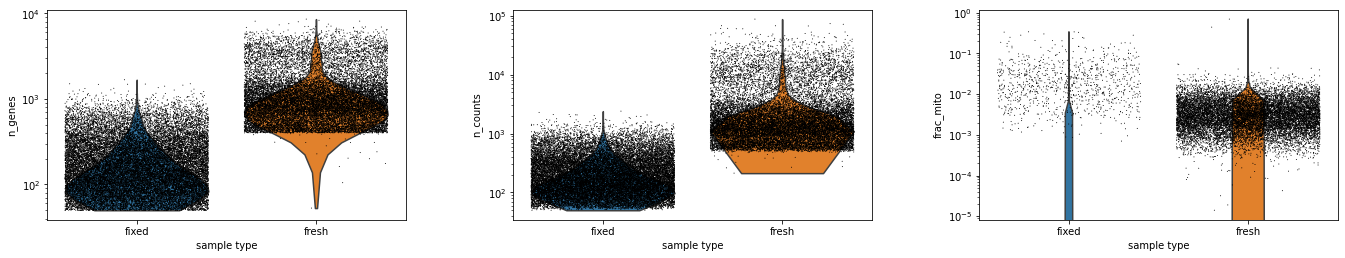

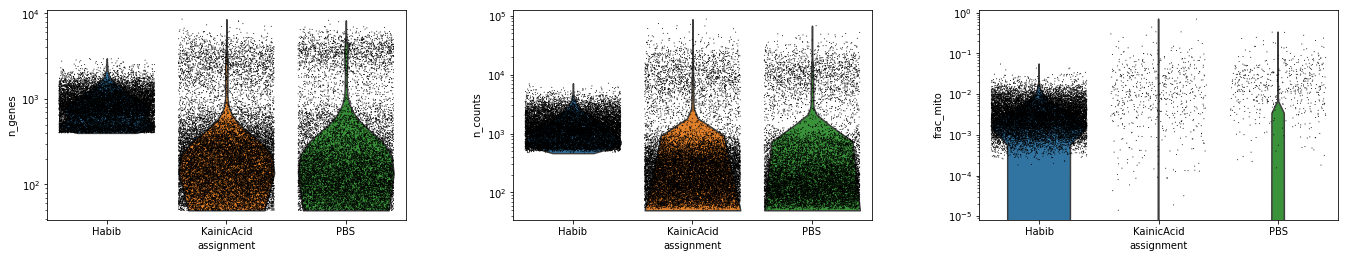

In [6]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'frac_mito'],
             groupby='sample_type', jitter=0.4, multi_panel=True, log=True, cut=0)

sc.pl.violin(adata, ['n_genes', 'n_counts', 'frac_mito'],
             groupby='assignment', jitter=0.4, multi_panel=True, log=True, cut=0)

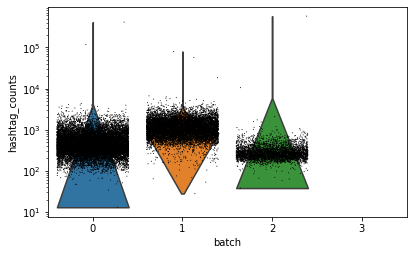

In [7]:
sc.pl.violin(adata, ['hashtag_counts'], 
             groupby='batch', jitter=0.4, multi_panel=True, log=True, cut=0)

In [8]:
# setup function for batch-specific thresholds
def batch_lims(batch): 
    if batch=='0': 
        min_ct, max_ct = 0, 900
    elif batch=='1':
        min_ct, max_ct = 0, 1200
    elif batch=='2':
        min_ct, max_ct = 300, 7500
    elif batch=='3':
        min_ct, max_ct = 450, 7500
        
    return min_ct, max_ct

def construct_batch_logical_gate(ad): 
    import operator
    batches = list(set(ad.obs['batch']))
    combined_bool = adata.obs['batch']==None
    for batch in batches: 
        lims_b = batch_lims(batch)
        bool_b = (adata.obs['batch']==batch) & \
                    (adata.obs['n_counts']>lims_b[0]) & \
                    (adata.obs['n_counts']<lims_b[1])
        combined_bool = operator.or_(combined_bool, bool_b)
    return combined_bool

(44201, 21711)


Trying to set attribute `.var` of view, copying.


(41556, 20679)


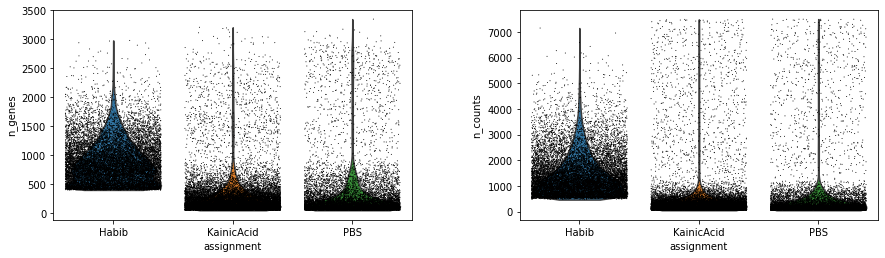

In [9]:
# secondary filtering

print(adata.shape)
filt_cond = construct_batch_logical_gate(adata)
adata = adata[filt_cond]

adata = adata[adata.obs['frac_mito']<0.05 ,:]
adata = adata[adata.obs['hashtag_counts']<5000]
sc.pp.filter_genes(adata, min_cells=2)
print(adata.shape)
sc.pl.violin(adata, ['n_genes', 'n_counts'],
             groupby='assignment',  
             jitter=0.4, multi_panel=True, log=False, cut=0)

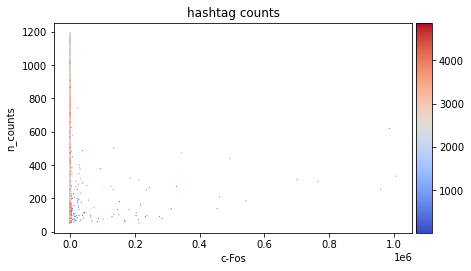

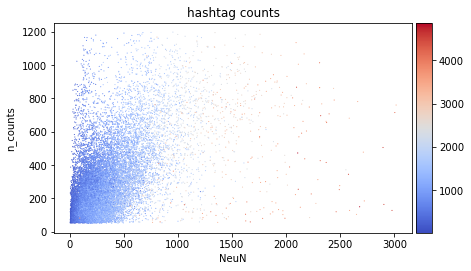

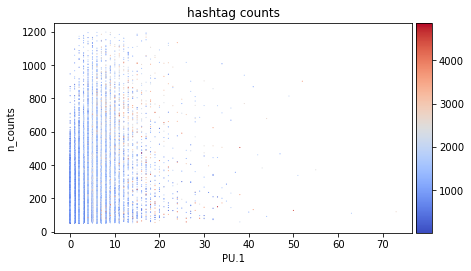

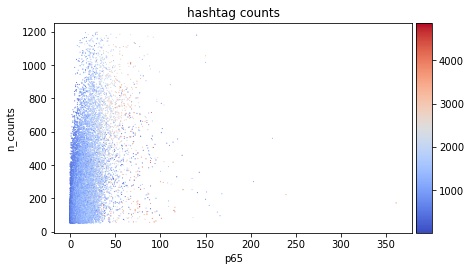

In [10]:
# filter out cells with outlier protein counts
ad_inCITE = adata[adata.obs['sample_type']=='fixed']
sc.pl.scatter(ad_inCITE, x='c-Fos', y='n_counts', color='hashtag_counts', color_map='coolwarm')
sc.pl.scatter(ad_inCITE, x='NeuN', y='n_counts', color='hashtag_counts', color_map='coolwarm')
sc.pl.scatter(ad_inCITE, x='PU.1', y='n_counts', color='hashtag_counts', color_map='coolwarm')
sc.pl.scatter(ad_inCITE, x='p65', y='n_counts', color='hashtag_counts', color_map='coolwarm')

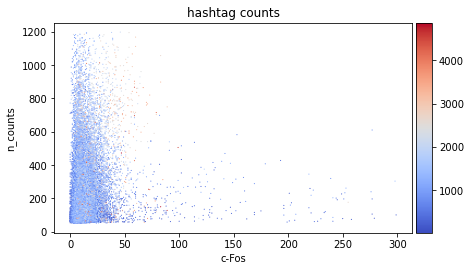

(41556, 20679)

In [11]:
cFos_thresh = 300
ad_inCITE = ad_inCITE[ad_inCITE.obs['c-Fos']<cFos_thresh]
sc.pl.scatter(ad_inCITE, x='c-Fos', y='n_counts', color='hashtag_counts', color_map='coolwarm')

In [15]:
# remove nuclei with extremely high c-Fos counts (likely due to protein aggregates)
adata = adata[((adata.obs['sample_type']=='fixed') & (adata.obs['c-Fos']<cFos_thresh)) | \
              (adata.obs['sample_type']=='fresh')]

In [16]:
# print stats
ncts = np.median(adata.obs['n_counts'])
ngens = np.median(adata.obs['n_genes'])
print('Median %0.2f counts, %0.2f genes' %(ncts, ngens))

# print batch & treatment stats
for batch in adata.obs.batch.cat.categories: 
    for assign in adata.obs.assignment.cat.categories: 
        num_cells = adata[((adata.obs['batch']==batch) & (adata.obs['assignment']==assign))].shape[0]
        print(batch, assign, num_cells)

Median 441.50 counts, 365.00 genes
0 Habib 0
0 KainicAcid 9405
0 PBS 5052
1 Habib 0
1 KainicAcid 5233
1 PBS 4754
2 Habib 0
2 KainicAcid 1087
2 PBS 800
3 Habib 15001
3 KainicAcid 0
3 PBS 0


In [17]:
ict.normalize_CITE(adata, antibodies)

# rename inCITE columns with disruptive characters
adata.obs['cFos_nCLR'] = adata.obs['c-Fos_nCLR'].copy()
adata.obs['PU1_nCLR'] = adata.obs['PU.1_nCLR'].copy()

print(adata.shape)

Trying to set attribute `.obs` of view, copying.


(41332, 20679)


In [19]:
# add layers: raw counts, ln(X+1) counts, z scores
adata.layers['raw_counts'] = adata.X.copy()

adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, layers=['counts'])

adata.layers['zscore'] = adata.layers['counts'].copy()
sc.pp.scale(adata, max_value=10, layer='zscore')

In [20]:
# add color code for treatment
adata.obs.assignment.cat.reorder_categories(new_categories=['PBS','KainicAcid','Habib'])
adata.obs['color'] = adata.obs['assignment'].map({'PBS':'#646464', 'KainicAcid':'#23b029', 'Habib':'#696969'})

In [21]:
adata.var.drop(columns=['robust-0','robust-1','robust-2'], inplace=True)

In [22]:
adata.write('./write/revision_filtered_concatenated_with_habib_good_inCITE.h5ad')

## Analysis - variable gene selection and kNN graph

In [6]:
adata = sc.read('./write/revision_filtered_concatenated_with_habib_good_inCITE.h5ad')

In [9]:
# log normalize
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

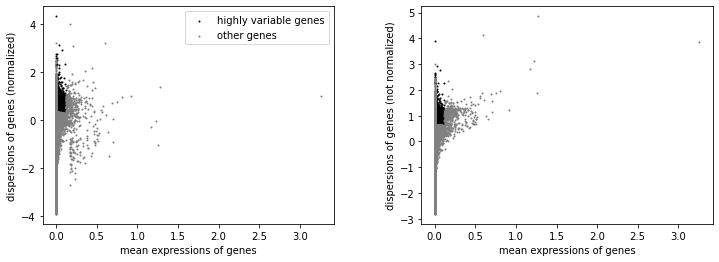

Found 7541 variables genes of 20679 total


In [10]:
sc.pp.highly_variable_genes(adata, min_mean=0.0015, max_mean=0.12, min_disp=0.31) # good
sc.pl.highly_variable_genes(adata, log=False)
print('Found %i variables genes of %i total' %(sum(adata.var['highly_variable']), adata.var.shape[0] ) )

In [11]:
# this takes a long time (~35 min on Terra VM with 208GB RAM)

import time
start = time.time()
sc.pp.regress_out(adata, ['n_counts','frac_mito'])
sc.pp.regress_out(adata, ['sample_type'])
sc.pp.scale(adata, max_value=10)
end = time.time()
print(end-start) # elapsed time (seconds)

1966.6751375198364


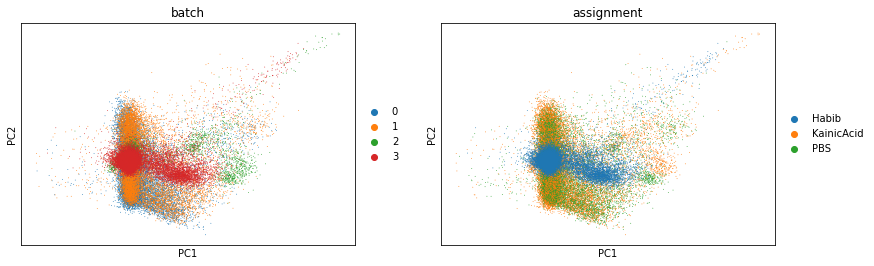

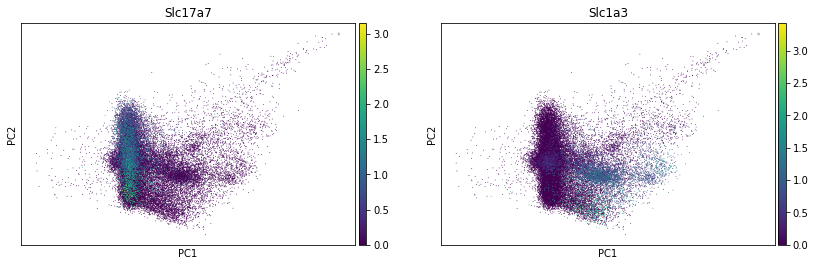

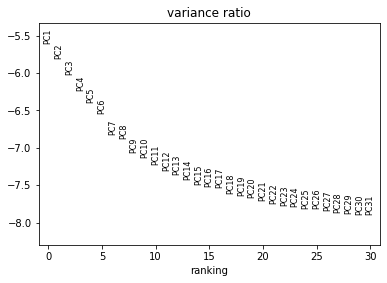

In [12]:
sc.pp.pca(adata, svd_solver='arpack', use_highly_variable=True)
sc.pl.pca(adata, color=['batch','assignment'])
sc.pl.pca(adata, color=['Slc17a7','Slc1a3'])
sc.pl.pca_variance_ratio(adata, log=True)

In [13]:
from harmony import harmonize
adata.obsm['X_harmony'] = harmonize(np.array(adata.obsm['X_pca']), 
                                    adata.obs, batch_key = ['batch','assignment','sample_type'])

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
Reach convergence after 9 iteration(s).


In [14]:
sc.pp.neighbors(adata, use_rep='X_harmony', n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

In [15]:
adata.write('./write/revision_clustered_with_habib_good_inCITE.h5ad')

## Analysis - clustering - remove low quality cluster and doublets

In [63]:
adata = sc.read('./write/revision_clustered_with_habib_good_inCITE.h5ad')

In [64]:
# make cluster palette
ania_palette = ['#CAE8F6',
                '#006E82', 
                '#005AC8', 
                '#bcbcbc', 
                '#F0F032',
                '#14D2DC',
                '#AA0A3C',
                '#FA2800', 
                '#FA7850', 
                '#FA5078', 
                '#96B400',
                '#0AB45A',
                '#FA78FA',
                '#A0FA82',
                '#FAE6BE',
                '#c8befa',
                '#E69F00',
                '#8214A0',
                '#f6d48f',
                '#00A0FA',
                '#82A0BE'
               ]

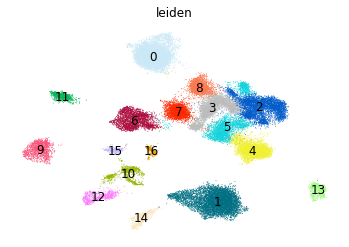

In [65]:
sc.tl.leiden(adata, resolution=0.7)
sc.pl.umap(adata, color=['leiden'], frameon=False, 
           legend_loc='on data', palette=ania_palette, 
           legend_fontweight='medium',
           legend_fontsize='large')

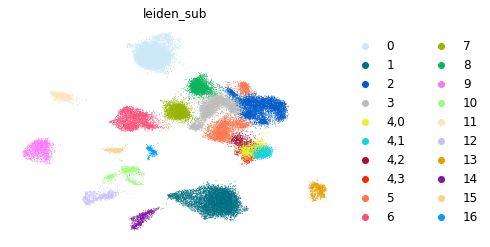

In [66]:
# identify contaminating cluster with multiple marker expression (tip of cluster 4)
sc.tl.leiden(adata, resolution=0.6,  restrict_to=('leiden', ['4']), key_added='leiden_sub')
sc.pl.umap(adata, color=['leiden_sub'], frameon=False, 
           palette=ania_palette, 
           legend_fontweight='medium',
           legend_fontsize='large')

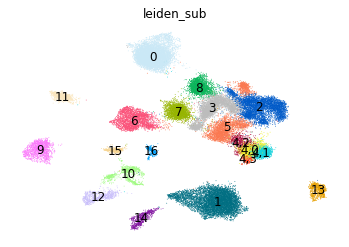

In [67]:
adata.uns['annot_colors_round1'] = ania_palette

sc.pl.umap(adata, color=['leiden_sub'], frameon=False, 
           legend_loc='on data', palette=ania_palette, 
           legend_fontweight='medium',
           legend_fontsize='large',
           save='_leiden_sub')

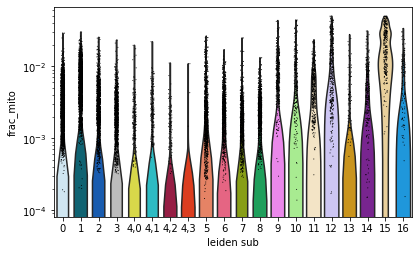

In [68]:
sc.pl.violin(adata, keys=['frac_mito'], groupby='leiden_sub', frameon=False, log=True, save='_mito_leiden_sub')

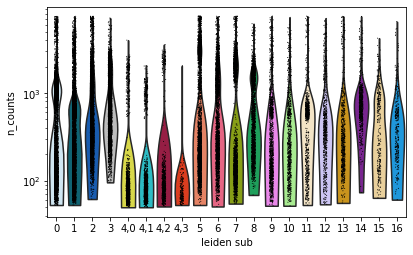

In [69]:
sc.pl.violin(adata, keys=['n_counts'], groupby='leiden_sub', frameon=False, log=True, save='_ncounts_leiden_sub')

In [70]:
sc.tl.rank_genes_groups(adata, 'leiden_sub')
leiden_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
pd.set_option('display.max_columns', None)
leiden_genes.head(20)

0        1        2       3            4,0      4,1            4,2  \
0     Lrrtm4     Cst3    Tshz2    Meg3            Cck    Pcdh8         Pcsk1n   
1     Kcnip4     Apoe    Ptprd  Snhg11          Cnih2     Tpt1         Tmsb10   
2     Lingo2   Slc1a2  Gm28928  Snap25           Nrgn     Nrn1            Cck   
3     Nkain2      Clu     Sgcz   Celf2         Pcsk1n     Pcp4          Npas4   
4      Celf2   Slc1a3   Snap25   Nrxn3            Pam     Actb           Junb   
5     Adarb2      Mt1   Atp1a3   Gria2          Acer1   Lingo1            Fos   
6    Gm28376     Gpc5     Syt1  Rnf112         Atp5g1    Ptgs2          Fxyd7   
7     Stxbp6      Mt2  Gm26883   Opcml           Pcp4     Rps2         Resp18   
8     Ppfia2   Atp1a2   Snhg11    Syt1         Spink8    Nptx2           Egr4   
9     Dock10  Sparcl1  Phactr1   Kcnq5          Usmg5    H2afz           Nrgn   
10      Erc2    Plpp3   Lrrc4c    Matk          Sepw1     Scg2        Prkar1b   
11   Tmem108      Ntm     Etl4    Ryr3           Actb  Ppp1r1a          Dusp1   
12    Ahcyl2    Wdr17    Vsnl1    Nrg3         Klhdc3    Epha7         Atp1a3   
13      Cdh9     Cd81    Pcsk2    Grm5  2210013O21Rik   Nhp2l1           Egr1   
14    Ppp3ca    Aldoc   Arpp21   Pde1a           Scg5    Srxn1          Ncald   
15    Dlgap1    Htra1  Slc17a7   Cadps          Ywhaz    Olfm1            Arc   
16  Il1rapl1    Ntsr2     Nrg1   Epha6  3632451O06Rik    Nptx1          Nr4a1   
17      Dab1     Bcan   Clstn1   Csmd1           Orc5    Epha4  1110008P14Rik   
18     Auts2  Gpr37l1     Meg3   Gria1       Sh3bgrl3      Arc         Gm9844   
19     Lrp1b     Gja1    Dpp10  Hs3st4       Catsperd   Cx3cl1          Rpl24   

        4,3              5        6              7              8       9  \
0       Ttr          Kcnq5    Erbb4        Galntl6        Galntl6    Plp1   
1      Cst3           Nrgn    Grip1  4930419G24Rik          Epha6   Ptgds   
2       Mt1         Tmsb10   Snhg11        Cntnap2           Meg3     Mag   
3     Ptgds  1110008P14Rik    Nrxn3          Epha6        Cntnap2   Pde4b   
4       Clu        Fam19a1  Galntl6         Hs6st3         Snhg11     Mog   
5       B2m         Mgat4c     Meg3          Kcnh7         Hs6st3  Cldn11   
6       Mt2            Cck    Kcnc2        Fam19a1          Celf2    St18   
7       Mt3  9530059O14Rik    Nxph1         Grin2b         Grin2b   Plcl1   
8    Slc1a2         Frmpd4    Gria4         Cacnb2  4930419G24Rik   Edil3   
9    Atp1a2           Syt1     Gad1          Pex5l         Atp2b1  Tmeff2   
10      Dbi         Hs3st4   Kcnmb2         Atp2b1           Dlg2     Mal   
11   Rps15a          Gng13  Cntnap2        Gm26905          Kcnd2   Prr5l   
12    Cmss1       Cntnap5c    Rbms3          Chrm3         Cacnb2   Pcdh9   
13   Atp1b2         Pcsk1n      Cit          Gria1          Kcnh7     Mbp   
14      Mgp            Ak5     Gad2         Slc8a1         Kcnip4    Apod   
15    Romo1          Stmn3    Unc5d           Msra        Fam19a1   Sept4   
16    Cox8a          Nrxn3     Xkr4          Ppm1e          Nrxn3  Nkain2   
17  Gm42418          Mgst3    Dpp10          Nrxn3          Gria1   Enpp2   
18    Gstm5          Cpne4   Gabrg3         Grin2a          Pex5l  Dock10   
19    Mfge8          Opcml    Pde4d         Snhg11         R3hdm1     Cnp   

          10        11       12             13             14       15  \
0      Ptgds    Lhfpl3    Ly6c1            Ttr           Apoe   mt-Co3   
1       Apod    Pcdh15   Slc2a1          Enpp2            Dbi   mt-Co1   
2        Vtn    Lrrc4c      Bsg  1500015O10Rik           Pltp  mt-Atp6   
3        Mgp       Tnr    Itm2a          Htr2c        Tmem212   mt-Nd1   
4     Atp1a2    Brinp3     Ly6a            Bsg        Rarres2   mt-Co2   
5   Slc6a20a     Dscam    Cldn5          Rpl41            Clu  mt-Cytb   
6      Cped1     Grid2   Igfbp7         Ndufa1           Nnat     Fth1   
7    Slc38a2    Ptprz1  Pglyrp1          Clic6            Mt3   mt-Nd4   
8        Ptn     Nxph1   

In [71]:
#remove mitochondrial cluster (15)
print(sum(adata.obs['leiden'].isin(['15'])))
adata = adata[~adata.obs['leiden'].isin(['15'])]

#remove low quality cluster (4,3)
print(sum(adata.obs['leiden_sub'].isin(['4,3'])))
adata = adata[~adata.obs['leiden_sub'].isin(['4,3'])]

327
179


### Identify and remove doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 16.0 seconds
Detected doublet rate = 7.6%
Estimated detectable doublet fraction = 22.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 33.4%
1085 doublets found for batch 0
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 11.2 seconds
Detected doublet rate = 7.8%
Estimated detectable doublet fraction = 25.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 31.0%
761 doublets found for batch 1
Preprocessing...
Si

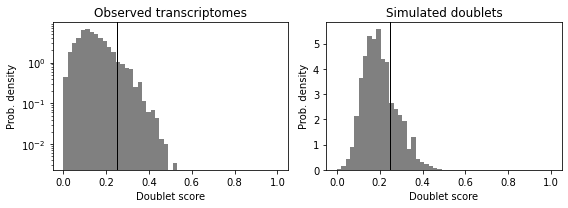

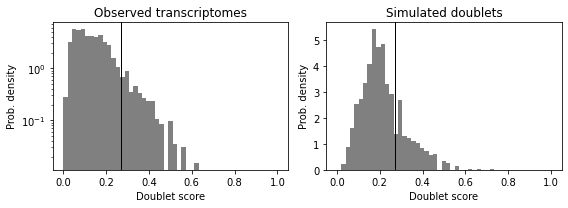

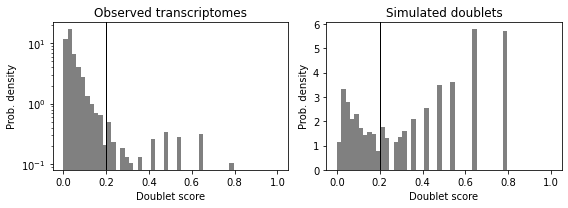

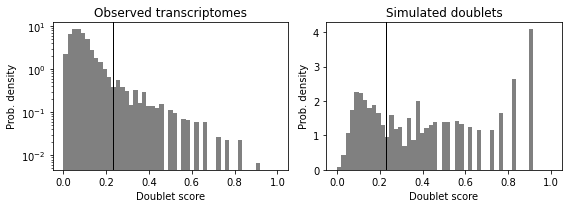

In [81]:
# identify doublets -- calculated by batch
adata.obs['doublet'] = False
adata.obs['doublet_scores'] = 0

import scrublet as scr

THRESH={'0':0.25,
        '1':0.27,
        '2':0.2,
        '3':0.23}

for batch in ['0','1','2','3']: 
    batch_thresh = THRESH[batch]
    counts_matrix = adata[adata.obs['batch']==batch].layers['raw_counts']
    
    scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.1)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=3, 
                                                              min_cells=3, 
                                                              min_gene_variability_pctl=80,
                                                              n_prin_comps=30)
    
    scrub.call_doublets(threshold=batch_thresh)
    scrub.plot_histogram();
    print('%i doublets found for batch %s' %(sum(doublet_scores>batch_thresh), batch) )

    adata.obs.at[adata.obs['batch']==batch, 'doublet'] = doublet_scores>batch_thresh
    adata.obs.at[adata.obs['batch']==batch, 'doublet_scores'] = doublet_scores

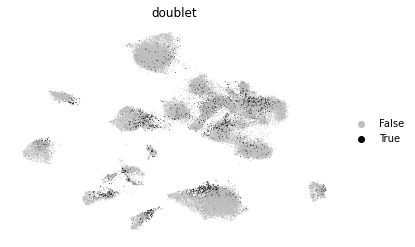

Total 3059 doublets


In [84]:
# plot doublets 
adata.obs['doublet'] = adata.obs['doublet'].astype('category')
sc.pl.umap(adata, color=['doublet'], palette=['#bfbfbf','#000000'], frameon=False, save='_doublet')

print('Total %i doublets' %sum(adata.obs['doublet']))

In [85]:
adata = adata[adata.obs['doublet']==False]
print(adata.shape)

(37767, 20679)


In [86]:
# shuffle adata rows for plotting categorical varibles in a visually well-mixed manner
adata_plot = sc.pp.subsample(adata, fraction=1, copy=True)

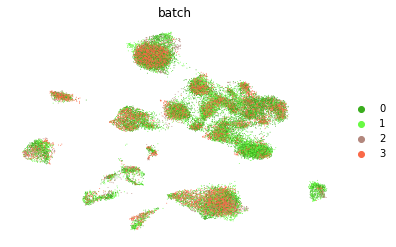

In [87]:
batch_colors = ['#3AAD1D','#68FA43','#B2877D','#FA6948']
sc.pl.umap(adata_plot, color='batch', palette=batch_colors, frameon=False, save='_allbatches')

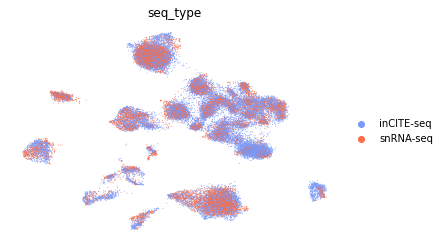

In [88]:
sample_type = {'fixed':'inCITE-seq', 'fresh':'snRNA-seq'}
adata_plot.obs['seq_type'] = adata_plot.obs['sample_type'].map(sample_type).astype('category')

batch_colors = ['#7A99FA','#FA6D48']
sc.pl.umap(adata_plot, color='seq_type', palette=batch_colors, sort_order=False, frameon=False, save='_seq_type')

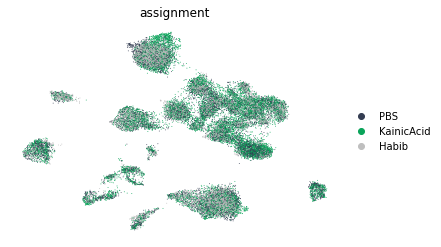

In [89]:
adata_plot.obs['assignment'].cat.reorder_categories(new_categories=['PBS','KainicAcid','Habib'], inplace=True)
sc.pl.umap(adata_plot, color=['assignment'], 
               frameon=False, 
               palette=['#343d52','#0AA45A','#bfbfbf'], 
               save='_treatment')

## Analysis - annotate

In [90]:
marker_genes_dict = {

    'PanEX':['Grin2b','Slc17a7'],
    'GABAergic':['Gad1','Sst','Npy'],
    'GranuleCells':['Stxbp6','Prox1'],
    'CA1':['Ndst4','Pex5l'],
    'CA2':['Pcp4'],
    'CA3':['Mgat4c','Car10'],
    'Subiculum':['Tshz2'],
    'Astrocytes':['Gja1','Slc1a3','Gfap'],
    'Oligo':['Plp1','Mag','Mog'],
    'OPC':['Vcan','Pdgfra','Tnr'],
    'ChoroidPlexus':['Enpp2'],
    'Endothelium':['Flt1','Cldn5'],
    'Fibroblast':['Ptgds','Slc7a11','Slc6a13'],
    'NPC':['Rarres2','Vim'],
    'Microglia':['Hexb','Csf1r','Cx3cr1'],
    'Pericytes':['Vtn','Ebf1']
}


Trying to set attribute `.uns` of view, copying.
categories: 0, 1, 2, etc.
var_group_labels: PanEX, GABAergic, GranuleCells, etc.


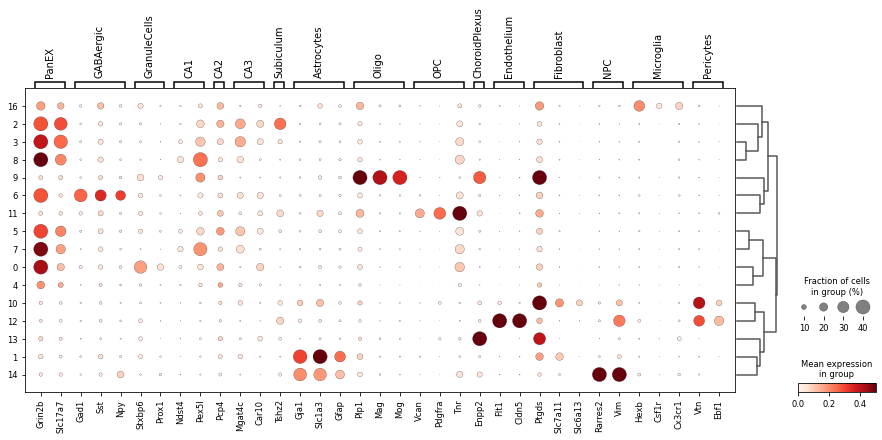

In [91]:
adata.uns.pop('dendrogram_leiden',None)
adata.uns.pop('dendrogram_annot',None)

ax = sc.pl.dotplot(adata, marker_genes_dict, groupby='leiden', 
                   vmax=0.5, dot_max=0.4, edgecolors='k', 
                   swap_axes=False, dendrogram=True,
                   save='_leiden_dendrogram')


In [92]:
leiden_to_annot = {'0': 'Ex.GranuleCell', 
                    '1': 'Astrocyte', 
                    '2': 'Ex.Subiculum.CA', 
                    '3': 'Ex.CA3.1',
                    '4': 'Ex.neuron.mixed',
                    '5': 'Ex.CA3.2',   
                    '6': 'GABAergic',  
                    '7': 'Ex.CA1.1', 
                    '8': 'Ex.CA1.2',
                    '9': 'Oligodendrocyte',  
                    '10': 'Fibroblast', 
                    '11': 'OPC', 
                    '12': 'Endothelium', 
                    '13':'ChoroidPlexus', 
                    '14':'NPC', 
                    '16':'Microglia', 
                    }

categories: Ex.GranuleCell, Astrocyte, Ex.Subiculum.CA, etc.
var_group_labels: PanEX, GABAergic, GranuleCells, etc.


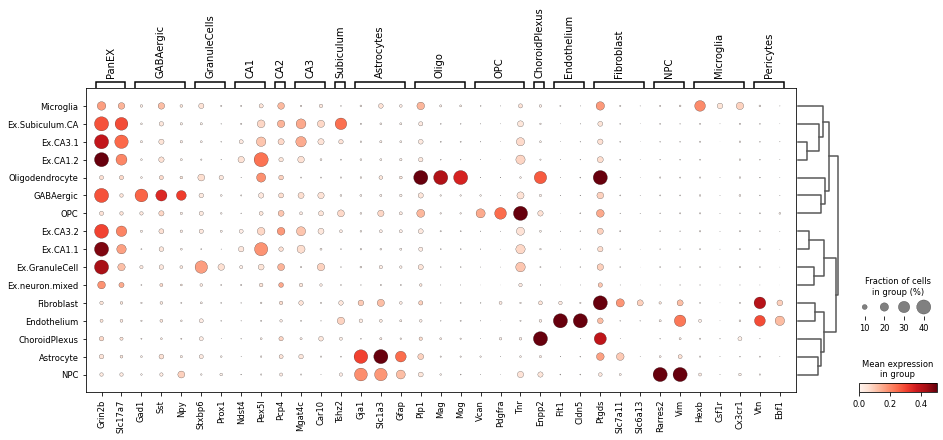

In [93]:
if 'annot' in adata.obs.columns: 
    print('dropping annot')
    adata.obs.drop(['annot'], axis=1, inplace=True)
if 'dendrogram_annot' in adata.uns.keys(): 
    print('dropping previous dendrogram')
    adata.uns.pop('dendrogram_leiden',None)
    adata.uns.pop('dendrogram_annot',None)

adata.obs['annot'] = adata.obs['leiden'].map(leiden_to_annot).astype('category')

ax = sc.pl.dotplot(adata, marker_genes_dict, groupby='annot', 
                   vmax=0.5, dot_max=0.4, edgecolors='k', 
                   swap_axes=False, dendrogram=True, save='_annot_dendrogram')

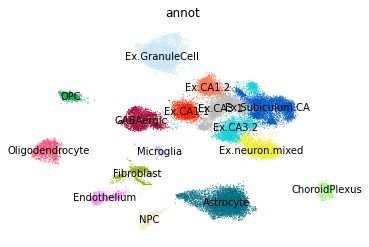

In [94]:
sc.pl.umap(adata, color=['annot'], frameon=False, 
           legend_loc='on data', palette=ania_palette, 
           legend_fontweight='medium',
           legend_fontsize='medium')

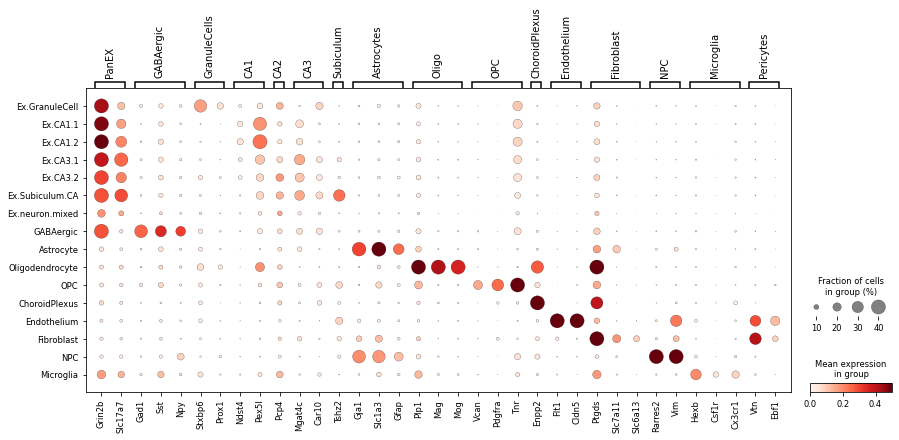

In [95]:
adata.obs['annot'].cat.reorder_categories(new_categories=['Ex.GranuleCell', # 0
                                                         'Ex.CA1.1', # 7
                                                         'Ex.CA1.2', # 8
                                                          'Ex.CA3.1', # 3
                                                          'Ex.CA3.2', # 5
                                                          'Ex.Subiculum.CA', # 2
                                                          'Ex.neuron.mixed', # 4
                                                          'GABAergic', # 6
                                                          'Astrocyte', # 1
                                                          'Oligodendrocyte', # 9
                                                          'OPC', # 11
                                                          'ChoroidPlexus', # 13
                                                          'Endothelium', # 12
                                                          'Fibroblast', # 10
                                                          'NPC', # 14
                                                          'Microglia' # 16
                                                         ], 
                                          inplace=True)

ax = sc.pl.dotplot(adata, marker_genes_dict, groupby='annot', 
                   vmax=0.5, dot_max=0.4, edgecolors='k', 
                   swap_axes=False, dendrogram=False, save='_annot_ordered')

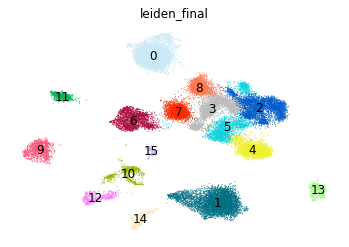

In [96]:
adata.obs['leiden_final'] = adata.obs['leiden'].copy()
adata.obs['leiden_final'].cat.add_categories(['15'], inplace=True)
adata.obs.loc[adata.obs['leiden']=='16', 'leiden_final'] = '15'
adata.obs['leiden_final'].cat.remove_unused_categories(inplace=True)

sc.pl.umap(adata, color=['leiden_final'], frameon=False, 
           legend_loc='on data', palette=ania_palette, 
           legend_fontweight='medium',
           legend_fontsize='large',
           save='_leiden_final')


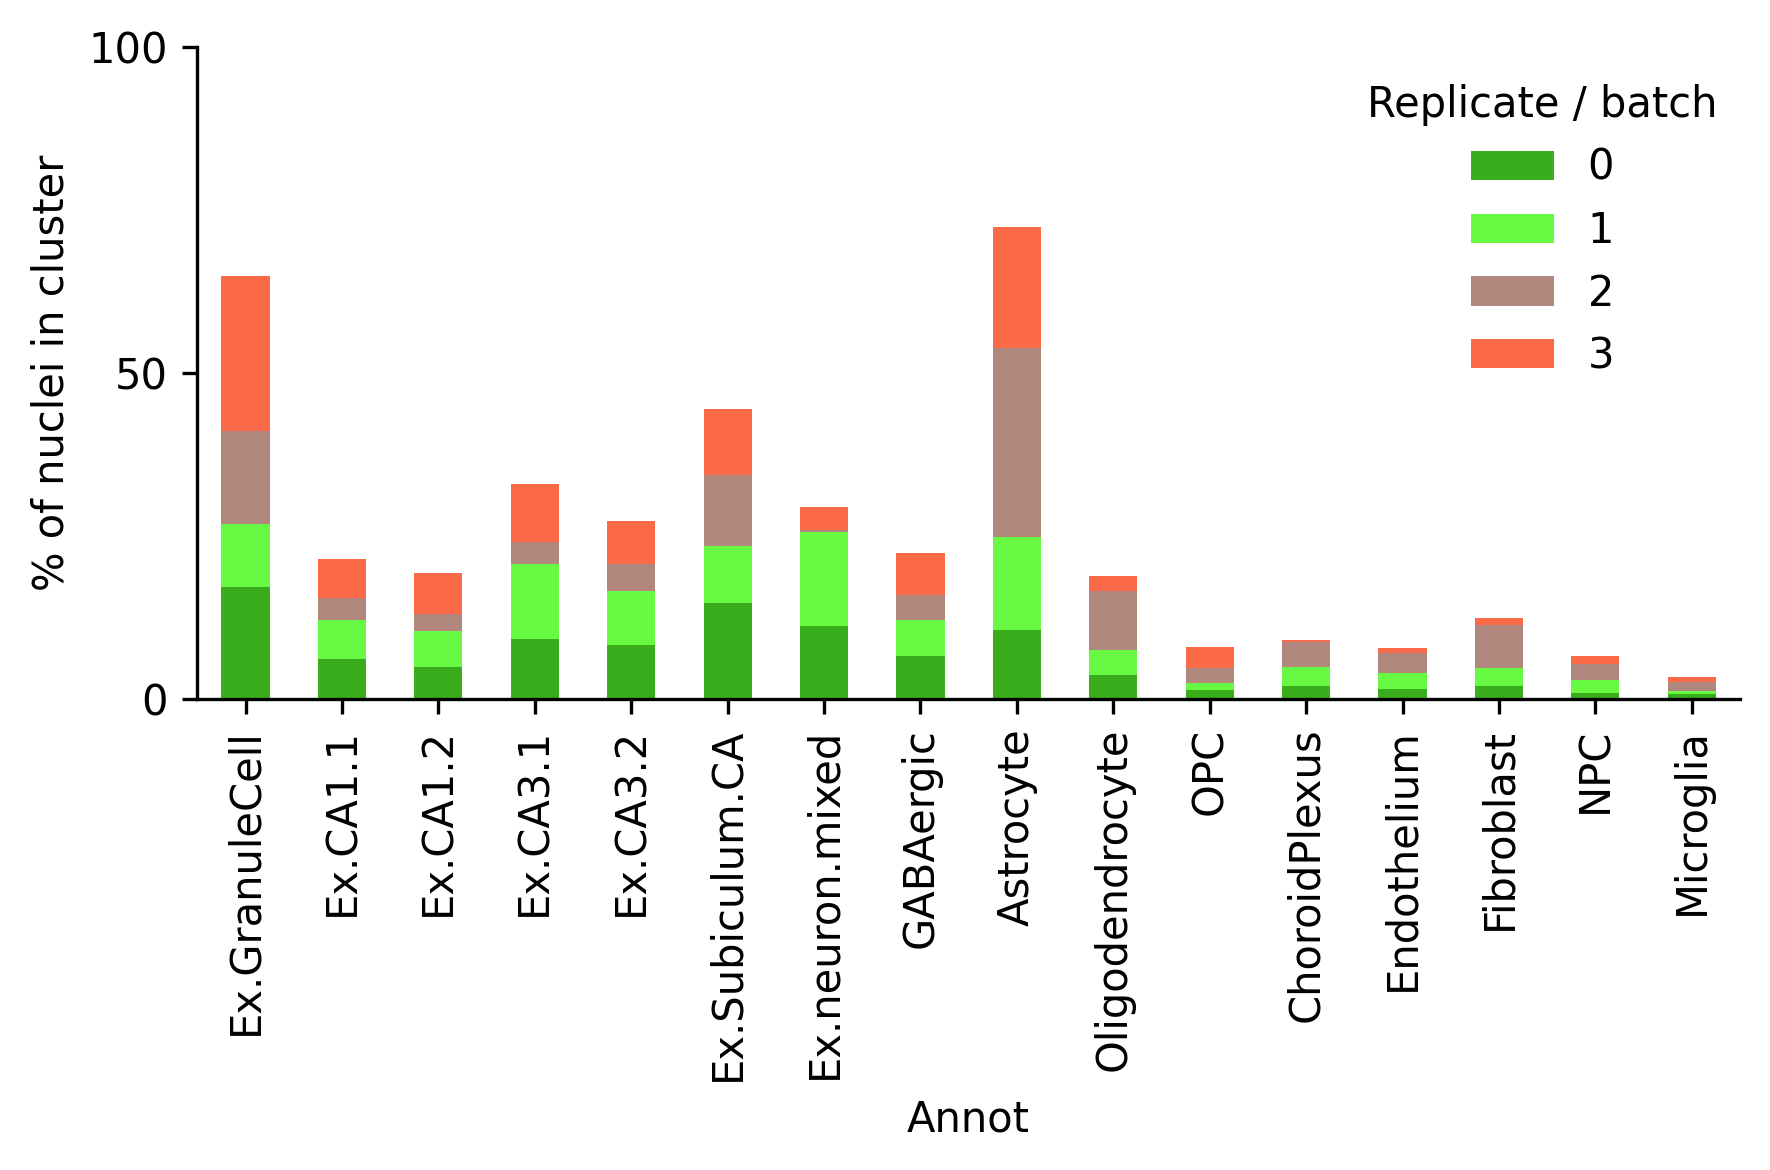

In [97]:
props = ict.get_cluster_proportions(adata, cluster_key='annot')

batch_colors = ['#3AAD1D','#68FA43','#B2877D','#FA6948']
fig = ict.plot_cluster_proportions(props.T, cluster_palette=batch_colors)
fig.savefig('%s/cluster_proportions.pdf' %sc.settings.figdir, bbox_inches='tight')

In [98]:
# remove unnecessary columns to reduce file size
adata.obs.drop(['Channel','demux_type','buffer','sample','brain_region',
                'genotype','x','age','doublet','doublet_scores'],
               axis=1, inplace=True)

In [99]:
adata.shape

(37767, 20679)

In [100]:
print(sum(adata.obs['sample_type']=='fixed'))
print(sum(adata.obs['sample_type']=='fresh'))

22260
15507


In [101]:
adata.write('./write/revision_clustered_with_habib_good_inCITE_annot.h5ad')

In [ ]:
# # write combined data to file
# out_path='write/submission_files'

# # gene expression matrix
# df = pd.DataFrame(data=adata.X.toarray(), 
#                  index=adata.obs_names, 
#                  columns=adata.var_names)
# df.T.to_csv('%s/mouse_hippocampus_adata_matrix.csv' %(out_path))

# # spliced
# df_sp = pd.DataFrame(data=adata.layers['spliced'].toarray(), 
#                  index=adata.obs_names, 
#                  columns=adata.var_names)
# df_sp.T.to_csv('%s/mouse_hippocampus_adata_matrix_spliced.csv' %(out_path))

# # unspliced
# df_un = pd.DataFrame(data=adata.layers['unspliced'].toarray(), 
#                  index=adata.obs_names, 
#                  columns=adata.var_names)
# df_un.T.to_csv('%s/mouse_hippocampus_adata_matrix_unspliced.csv' %(out_path))


# # gene names
# adata.var.to_csv('%s/mouse_hippocampus_adata_var.csv' %(out_path))

# # barcodes / nuclei and metadata
# adata_obs_sub = adata.obs[['n_genes', 'n_counts', 'demux_type', 'assignment', 'p65', 'c-Fos', 'NeuN', 'PU.1', 'hashtag_counts', 'batch']]
# adata_obs_sub.to_csv('%s/mouse_hippocampus_adata_obs.csv' %(out_path))

In [ ]:
adata = sc.read('./write/revision_clustered_with_habib_good_inCITE_annot.h5ad')

In [9]:
adi = adata[adata.obs['sample_type']=='fixed']
df = pd.DataFrame(adi.layers['counts'].toarray(), columns=adi.var.index, index=adi.obs.index)
df.to_csv('matrix_log1p.csv')

## Cluster snRNA-seq of inCITE data alone

In [114]:
adata = sc.read('./write/revision_filtered_concatenated_with_habib_good_inCITE.h5ad')

In [115]:
adata_inCITE = adata[adata.obs['sample_type']=='fixed']

In [116]:
adata_inCITE

View of AnnData object with n_obs × n_vars = 24444 × 20679
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'p65', 'c-Fos', 'NeuN', 'PU.1', 'hashtag_counts', 'buffer', 'sample', 'brain_region', 'genotype', 'x', 'age', 'batch', 'sample_type', 'frac_mito', 'p65_norm', 'p65_nCLR', 'c-Fos_norm', 'c-Fos_nCLR', 'NeuN_norm', 'NeuN_nCLR', 'PU.1_norm', 'PU.1_nCLR', 'cFos_nCLR', 'PU1_nCLR', 'color'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'n_cells', 'mean', 'std'
    uns: 'assignment_colors', 'batch_colors', 'sample_type_colors'
    obsm: 'raw_probs'
    layers: 'counts', 'raw_counts', 'zscore'

In [66]:
# log normalize
sc.pp.normalize_total(adata_inCITE)
sc.pp.log1p(adata_inCITE)
adata_inCITE.raw = adata_inCITE

/home/jupyter-user/notebooks/packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.


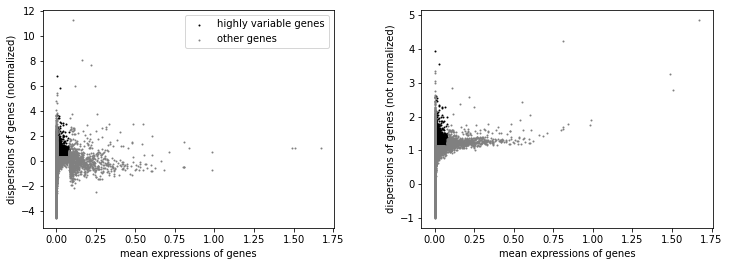

Found 5194 variables genes of 20679 total


In [68]:
sc.pp.highly_variable_genes(adata_inCITE, min_mean=0.004, max_mean=0.08, min_disp=0.3) # 
sc.pl.highly_variable_genes(adata_inCITE, log=False)
print('Found %i variables genes of %i total' %(sum(adata_inCITE.var['highly_variable']), 
                                               adata_inCITE.var.shape[0] ) )

In [69]:
import time
start = time.time()
sc.pp.regress_out(adata_inCITE, ['n_counts','frac_mito'])
sc.pp.scale(adata_inCITE, max_value=10)
end = time.time()
print(end-start) # elapsed time (seconds)

1156.4981062412262


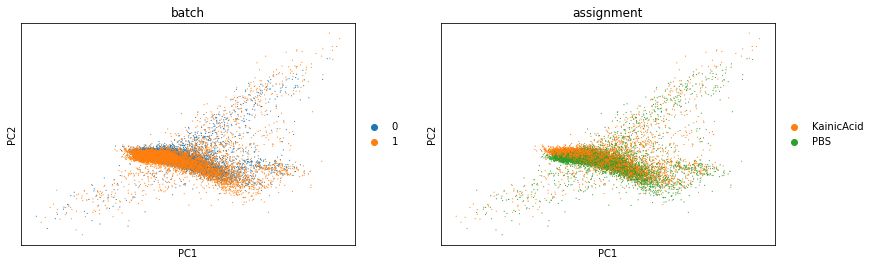

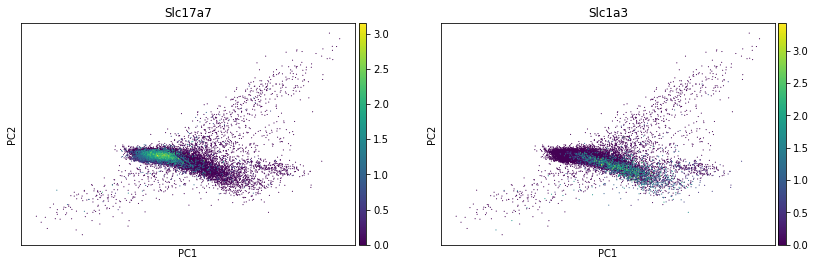

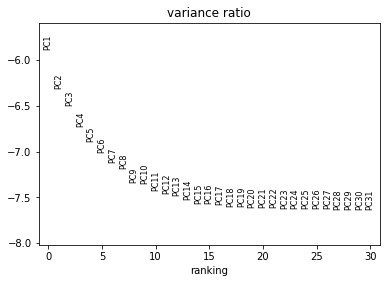

In [70]:
sc.pp.pca(adata_inCITE, svd_solver='arpack', use_highly_variable=True)
sc.pl.pca(adata_inCITE, color=['batch','assignment'])
sc.pl.pca(adata_inCITE, color=['Slc17a7','Slc1a3'])
sc.pl.pca_variance_ratio(adata_inCITE, log=True)

In [71]:
from harmony import harmonize
adata_inCITE.obsm['X_harmony'] = harmonize(np.array(adata_inCITE.obsm['X_pca']), 
                                    adata_inCITE.obs, batch_key = ['batch','assignment'])

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


In [72]:
sc.pp.neighbors(adata_inCITE, use_rep='X_harmony', n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_inCITE)
sc.tl.leiden(adata_inCITE, resolution=1)

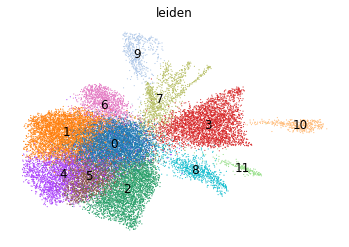

In [73]:
sc.pl.umap(adata_inCITE, color=['leiden'], frameon=False, 
           legend_loc='on data', 
           legend_fontweight='medium',
           legend_fontsize='large',
           save='_inCITE_leiden')

In [74]:
sc.tl.rank_genes_groups(adata_inCITE, 'leiden')
leiden_genes = pd.DataFrame(adata_inCITE.uns['rank_genes_groups']['names'])
pd.set_option('display.max_columns', None)
leiden_genes.head(20)

0              1       2        3        4              5        6  \
0        Cck         Atp1a3   Pcdh8     Cst3     Meg3           Meg3     Gad2   
1       Nrgn         Tmsb10   Epha7      Mt1   Snhg11         Snhg11     Gad1   
2      Sepw1        Slc17a7    Nrn1     Apoe    Celf2        Sipa1l3      Sst   
3     Pcsk1n  1110008P14Rik   Ptgs2      Clu   Kcnip4          Nrxn3   Pcsk1n   
4     Tmsb10           Dnm1    Tpt1      Mt2     Dlg2         Rnf112      Npy   
5      Fxyd7         Clstn1  Homer1   Slc1a2   Hs6st3          Celf2    Erbb4   
6      Usmg5          Vsnl1   Celf2      Mt3    Csmd1           Hat1    Pvalb   
7      Stmn3         Snap25   Nptx2  Sparcl1    Epha6        Fam19a1     Cort   
8      Cnih2          Ndrg4     Abr   Slc1a3    Opcml          Spag5     Cnr1   
9     Atp1a3         Atp2b2    Bdnf   Atp1a2    Kcnd2          Cadps   Cox6a2   
10      Rtn1         Gabra1  Dock10  Gpr37l1  Gm17660       Arhgap21     Pnoc   
11     Calm2           Nrgn    Dlg2    Htra1   R3hdm1  2010111I01Rik  Slc32a1   
12  Sh3bgrl3          Aldoa  Brinp1    Aldoc     Nrg3            Dcc    Rab3b   
13      Hpca           Gnas   Mapk4   Atp1b2  Cntnap2          Cpne6     Meg3   
14     Olfm1            Cck  Kcnip4      Dbi    Pex5l          Sepw1    Kcnc2   
15      Caly          Uchl1  Adgrl3    Ntsr2    Nrxn3          Epha6   Resp18   
16      Ly6h         Syngr1    Rgs7    Plpp3  Galntl6          Mylip    Cplx1   
17    Dynll1           Rtn1   Inhba     Cd81    Mylip           Kri1  Gm13889   
18    Polr1d          Syt11  Arpp21     Gja1    Ptprd          Gria2  Galntl6   
19    Atp2b1           Thy1   Kcnd2   Cldn10   Atp2b1           Ryr3   Ndufa4   

                7       8        9             10       11  
0             Ttr    Plp1    Ly6c1            Dbi   mt-Co3  
1           Ptgds   Ptgds   Slc2a1           Apoe  mt-Atp6  
2           Enpp2  Cldn11     Ly6a            Mt3   mt-Co1  
3   1500015O10Rik     Mal  Pglyrp1            Clu     Fth1  
4            Apod     Mag    Itm2a            Mt1      Mt1  
5             Mgp     Mog      Bsg           Pltp   mt-Co2  
6             Vtn     Cnp  Rps27rt        Rarres2      Ttr  
7          Igfbp2    Scd2    Rpl38            Vim    Rps21  
8            Igf2  Tspan2    Rps24           Nnat    Rps20  
9            Cst3   Cryab     Pltp        Tmem212    Rpl41  
10          Cox8a    Apod   Tmsb4x         Tuba1a    Ptgds  
11        Rps27rt   Sept4    Rpl41            Mt2     Cst3  
12            Fn1  Tubb4a   Igfbp7         Tubb4b    Rpl37  
13           Gng5   Enpp2    Rpl39          Itm2c  mt-Cytb  
14          Trpm3  Phldb1    Rps20        Chchd10      Mt3  
15          Rpl41     Mbp   Rpl35a           Scd2  Rps27rt  
16          Timp3    Sgk1   Ctla2a          Gstm1      Dbi  
17          Fxyd1   Pcdh9    Rps29          Prelp  Gm14820  
18         Ifitm3   Kndc1   Gm9843        Ccdc153   Tmsb4x  
19       Slc6a20a    Map7    Cldn5  4933434E20Rik    Rpl39

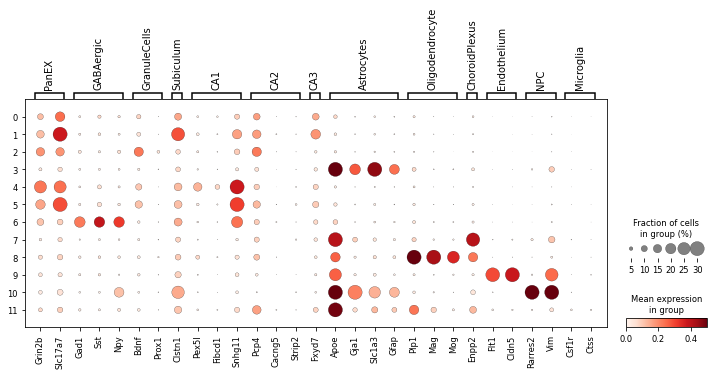

In [89]:
marker_genes_dict = {
    'PanEX':['Grin2b','Slc17a7'],
    'GABAergic':['Gad1','Sst','Npy'],
    'GranuleCells':['Bdnf','Prox1'],
    'Subiculum':['Clstn1'],
    'CA1':['Pex5l','Fibcd1','Snhg11'],
    'CA2':['Pcp4','Cacng5','Strip2'],
    'CA3':['Fxyd7'],
    'Astrocytes':['Apoe','Gja1','Slc1a3','Gfap'],
    'Oligodendrocyte':['Plp1','Mag','Mog'],
    'ChoroidPlexus':['Enpp2'],
    'Endothelium':['Flt1','Cldn5'],
    'NPC':['Rarres2','Vim'],
    'Microglia':['Csf1r','Ctss'],
}

marker_genes = ['Slc17a7','Slc1a3','Atp2b1','Bdnf','Stxbp6','Pex5l','Pcp4','Mgat4c','Cck','Sipa1l3',
                             'Gad1','Sst','Calb2','Acta2', 'Enpp2','Mog','Flt1','Vim','Vtn','Slc7a11',
                             'Hexb','Ctss','Csf1r']

sc.pl.dotplot(adata_inCITE, marker_genes_dict, 
                              groupby='leiden', vmax=0.5, dot_max=0.3,
                             save='_inCITE_leiden')

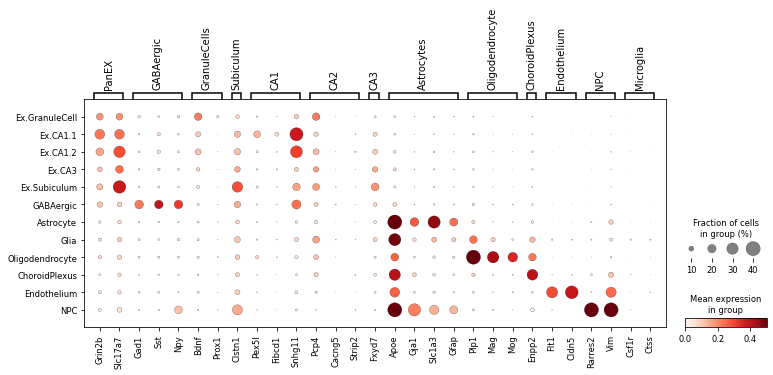

In [96]:
leiden_to_annot = {'0': 'Ex.CA3',
                    '1': 'Ex.Subiculum',
                    '2': 'Ex.GranuleCell',
                    '3': 'Astrocyte', 
                    '4': 'Ex.CA1.1',
                    '5': 'Ex.CA1.2',
                    '6': 'GABAergic',
                    '7': 'ChoroidPlexus',
                    '8': 'Oligodendrocyte', 
                    '9': 'Endothelium',
                    '10': 'NPC',
                    '11': 'Glia',
                    }

# adata_inCITE.obs.drop(['annot'], axis=1, inplace=True)
# adata_inCITE.uns.pop('dendrogram_annot',None)
adata_inCITE.obs['annot'] = adata_inCITE.obs['leiden'].map(leiden_to_annot).astype('category')
adata_inCITE.obs['annot'].cat.reorder_categories(new_categories=['Ex.GranuleCell', # 2
                                                                'Ex.CA1.1', # 4
                                                                'Ex.CA1.2', # 5
                                                                'Ex.CA3', # 0
                                                                'Ex.Subiculum', # 1
                                                                'GABAergic', # 6
                                                                'Astrocyte', # 3
                                                                 'Glia', # 11
                                                                'Oligodendrocyte', # 8
                                                                'ChoroidPlexus', # 7
                                                                 'Endothelium', # 9
                                                                 'NPC' # 10
                                                                ], 
                                                 inplace=True)

ax = sc.pl.dotplot(adata_inCITE, marker_genes_dict, groupby='annot',
                   vmax=0.5, dot_max=0.4, edgecolors='k', 
                   swap_axes=False, dendrogram=False, save='_inCITE_ordered')

In [102]:
# remove unnecessary columns to reduce file size
adata_inCITE.obs.drop(['Channel','demux_type','buffer','sample','brain_region',
                'genotype','x','age'],
               axis=1, inplace=True)

In [103]:
adata_inCITE.write('./write/revision_inCITE_clustered.h5ad')